In [ ]:
import torch
from torch.utils.data import sampler
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms


def get_dataloaders_mnist(batch_size, num_workers=0,
                          validation_fraction=None,
                          train_transforms=None,
                          test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=train_transforms,
                                   download=True)

    valid_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=test_transforms)

    test_dataset = datasets.MNIST(root='data',
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 60000)
        train_indices = torch.arange(0, 60000 - num)
        valid_indices = torch.arange(60000 - num, 60000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)

    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader

In [ ]:
# imports from installed libraries
import os
import numpy as np
import random
import torch
from distutils.version import LooseVersion as Version


def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    if torch.__version__ <= Version("1.7"):
        torch.set_deterministic(True)
    else:
        torch.use_deterministic_algorithms(True)


def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
import time
import torch
from helper_evaluation import compute_accuracy


def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer, device):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % 50:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

In [ ]:
{
 "cells": [
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "STAT 453: Deep Learning (Spring 2021)  \n",
    "Instructor: Sebastian Raschka (sraschka@wisc.edu)  \n",
    "\n",
    "Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  \n",
    "GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21\n",
    "\n",
    "---"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 1,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Author: Sebastian Raschka\n",
      "\n",
      "Python implementation: CPython\n",
      "Python version       : 3.9.2\n",
      "IPython version      : 7.20.0\n",
      "\n",
      "torch: 1.9.0a0+d819a21\n",
      "\n"
     ]
    }
   ],
   "source": [
    "%load_ext watermark\n",
    "%watermark -a 'Sebastian Raschka' -v -p torch"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# MLP with Dropout "
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Imports"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 2,
   "metadata": {},
   "outputs": [],
   "source": [
    "import torch\n",
    "import numpy as np\n",
    "import matplotlib.pyplot as plt"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 3,
   "metadata": {},
   "outputs": [],
   "source": [
    "# From local helper files\n",
    "from helper_evaluation import set_all_seeds, set_deterministic\n",
    "from helper_train import train_model\n",
    "from helper_plotting import plot_training_loss, plot_accuracy, show_examples\n",
    "from helper_dataset import get_dataloaders_mnist"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Settings and Dataset"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 4,
   "metadata": {},
   "outputs": [],
   "source": [
    "##########################\n",
    "### SETTINGS\n",
    "##########################\n",
    "\n",
    "RANDOM_SEED = 123\n",
    "BATCH_SIZE = 256\n",
    "NUM_HIDDEN_1 = 75\n",
    "NUM_HIDDEN_2 = 45\n",
    "NUM_EPOCHS = 50\n",
    "DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 5,
   "metadata": {},
   "outputs": [],
   "source": [
    "set_all_seeds(RANDOM_SEED)\n",
    "set_deterministic()"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 6,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Image batch dimensions: torch.Size([256, 1, 28, 28])\n",
      "Image label dimensions: torch.Size([256])\n",
      "Class labels of 10 examples: tensor([4, 5, 8, 9, 9, 4, 9, 9, 3, 9])\n"
     ]
    }
   ],
   "source": [
    "##########################\n",
    "### MNIST DATASET\n",
    "##########################\n",
    "\n",
    "train_loader, valid_loader, test_loader = get_dataloaders_mnist(\n",
    "    batch_size=BATCH_SIZE,\n",
    "    validation_fraction=0.1)\n",
    "\n",
    "# Checking the dataset\n",
    "for images, labels in train_loader:  \n",
    "    print('Image batch dimensions:', images.shape)\n",
    "    print('Image label dimensions:', labels.shape)\n",
    "    print('Class labels of 10 examples:', labels[:10])\n",
    "    break"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Model"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 7,
   "metadata": {},
   "outputs": [],
   "source": [
    "class MultilayerPerceptron(torch.nn.Module):\n",
    "\n",
    "    def __init__(self, num_features, num_classes, drop_proba, \n",
    "                 num_hidden_1, num_hidden_2):\n",
    "        super().__init__()\n",
    "        \n",
    "        self.my_network = torch.nn.Sequential(\n",
    "            # 1st hidden layer\n",
    "            torch.nn.Flatten(),\n",
    "            torch.nn.Linear(num_features, num_hidden_1),\n",
    "            torch.nn.ReLU(),\n",
    "            # 2nd hidden layer\n",
    "            torch.nn.Linear(num_hidden_1, num_hidden_2),\n",
    "            torch.nn.ReLU(),\n",
    "            # output layer\n",
    "            torch.nn.Linear(num_hidden_2, num_classes)\n",
    "        )\n",
    "\n",
    "        for m in self.modules():\n",
    "            if isinstance(m, torch.nn.Linear):\n",
    "                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')\n",
    "                if m.bias is not None:\n",
    "                    m.bias.detach().zero_()\n",
    "           \n",
    "    def forward(self, x):\n",
    "        logits = self.my_network(x)\n",
    "        return logits"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 8,
   "metadata": {},
   "outputs": [
    {
     "name": "stdout",
     "output_type": "stream",
     "text": [
      "Epoch: 001/050 | Batch 0000/0210 | Loss: 2.6304\n",
      "Epoch: 001/050 | Batch 0050/0210 | Loss: 0.6442\n",
      "Epoch: 001/050 | Batch 0100/0210 | Loss: 0.3852\n",
      "Epoch: 001/050 | Batch 0150/0210 | Loss: 0.3313\n",
      "Epoch: 001/050 | Batch 0200/0210 | Loss: 0.2585\n",
      "Epoch: 001/050 | Train: 90.83% | Validation: 92.57%\n",
      "Time elapsed: 0.04 min\n",
      "Epoch: 002/050 | Batch 0000/0210 | Loss: 0.2815\n",
      "Epoch: 002/050 | Batch 0050/0210 | Loss: 0.3328\n",
      "Epoch: 002/050 | Batch 0100/0210 | Loss: 0.2883\n",
      "Epoch: 002/050 | Batch 0150/0210 | Loss: 0.2684\n",
      "Epoch: 002/050 | Batch 0200/0210 | Loss: 0.2473\n",
      "Epoch: 002/050 | Train: 92.97% | Validation: 94.52%\n",
      "Time elapsed: 0.08 min\n",
      "Epoch: 003/050 | Batch 0000/0210 | Loss: 0.2372\n",
      "Epoch: 003/050 | Batch 0050/0210 | Loss: 0.2116\n",
      "Epoch: 003/050 | Batch 0100/0210 | Loss: 0.2541\n",
      "Epoch: 003/050 | Batch 0150/0210 | Loss: 0.2408\n",
      "Epoch: 003/050 | Batch 0200/0210 | Loss: 0.2203\n",
      "Epoch: 003/050 | Train: 93.88% | Validation: 94.83%\n",
      "Time elapsed: 0.12 min\n",
      "Epoch: 004/050 | Batch 0000/0210 | Loss: 0.2231\n",
      "Epoch: 004/050 | Batch 0050/0210 | Loss: 0.2356\n",
      "Epoch: 004/050 | Batch 0100/0210 | Loss: 0.1415\n",
      "Epoch: 004/050 | Batch 0150/0210 | Loss: 0.2173\n",
      "Epoch: 004/050 | Batch 0200/0210 | Loss: 0.2429\n",
      "Epoch: 004/050 | Train: 94.85% | Validation: 95.87%\n",
      "Time elapsed: 0.17 min\n",
      "Epoch: 005/050 | Batch 0000/0210 | Loss: 0.2001\n",
      "Epoch: 005/050 | Batch 0050/0210 | Loss: 0.2025\n",
      "Epoch: 005/050 | Batch 0100/0210 | Loss: 0.1999\n",
      "Epoch: 005/050 | Batch 0150/0210 | Loss: 0.1198\n",
      "Epoch: 005/050 | Batch 0200/0210 | Loss: 0.1724\n",
      "Epoch: 005/050 | Train: 95.45% | Validation: 96.30%\n",
      "Time elapsed: 0.21 min\n",
      "Epoch: 006/050 | Batch 0000/0210 | Loss: 0.1295\n",
      "Epoch: 006/050 | Batch 0050/0210 | Loss: 0.1204\n",
      "Epoch: 006/050 | Batch 0100/0210 | Loss: 0.1118\n",
      "Epoch: 006/050 | Batch 0150/0210 | Loss: 0.1166\n",
      "Epoch: 006/050 | Batch 0200/0210 | Loss: 0.1384\n",
      "Epoch: 006/050 | Train: 95.97% | Validation: 96.60%\n",
      "Time elapsed: 0.25 min\n",
      "Epoch: 007/050 | Batch 0000/0210 | Loss: 0.1115\n",
      "Epoch: 007/050 | Batch 0050/0210 | Loss: 0.1338\n",
      "Epoch: 007/050 | Batch 0100/0210 | Loss: 0.1799\n",
      "Epoch: 007/050 | Batch 0150/0210 | Loss: 0.1260\n",
      "Epoch: 007/050 | Batch 0200/0210 | Loss: 0.0729\n",
      "Epoch: 007/050 | Train: 96.25% | Validation: 96.73%\n",
      "Time elapsed: 0.29 min\n",
      "Epoch: 008/050 | Batch 0000/0210 | Loss: 0.0716\n",
      "Epoch: 008/050 | Batch 0050/0210 | Loss: 0.1397\n",
      "Epoch: 008/050 | Batch 0100/0210 | Loss: 0.1150\n",
      "Epoch: 008/050 | Batch 0150/0210 | Loss: 0.1204\n",
      "Epoch: 008/050 | Batch 0200/0210 | Loss: 0.1702\n",
      "Epoch: 008/050 | Train: 96.65% | Validation: 96.82%\n",
      "Time elapsed: 0.33 min\n",
      "Epoch: 009/050 | Batch 0000/0210 | Loss: 0.1395\n",
      "Epoch: 009/050 | Batch 0050/0210 | Loss: 0.0790\n",
      "Epoch: 009/050 | Batch 0100/0210 | Loss: 0.1281\n",
      "Epoch: 009/050 | Batch 0150/0210 | Loss: 0.1371\n",
      "Epoch: 009/050 | Batch 0200/0210 | Loss: 0.1558\n",
      "Epoch: 009/050 | Train: 96.95% | Validation: 97.00%\n",
      "Time elapsed: 0.37 min\n",
      "Epoch: 010/050 | Batch 0000/0210 | Loss: 0.0931\n",
      "Epoch: 010/050 | Batch 0050/0210 | Loss: 0.0632\n",
      "Epoch: 010/050 | Batch 0100/0210 | Loss: 0.0804\n",
      "Epoch: 010/050 | Batch 0150/0210 | Loss: 0.1356\n",
      "Epoch: 010/050 | Batch 0200/0210 | Loss: 0.1289\n",
      "Epoch: 010/050 | Train: 97.22% | Validation: 97.17%\n",
      "Time elapsed: 0.41 min\n",
      "Epoch: 011/050 | Batch 0000/0210 | Loss: 0.0819\n",
      "Epoch: 011/050 | Batch 0050/0210 | Loss: 0.1124\n",
      "Epoch: 011/050 | Batch 0100/0210 | Loss: 0.1127\n",
      "Epoch: 011/050 | Batch 0150/0210 | Loss: 0.1042\n",
      "Epoch: 011/050 | Batch 0200/0210 | Loss: 0.0829\n",
      "Epoch: 011/050 | Train: 97.50% | Validation: 97.32%\n",
      "Time elapsed: 0.45 min\n",
      "Epoch: 012/050 | Batch 0000/0210 | Loss: 0.0725\n",
      "Epoch: 012/050 | Batch 0050/0210 | Loss: 0.1134\n",
      "Epoch: 012/050 | Batch 0100/0210 | Loss: 0.0891\n",
      "Epoch: 012/050 | Batch 0150/0210 | Loss: 0.0569\n",
      "Epoch: 012/050 | Batch 0200/0210 | Loss: 0.1140\n",
      "Epoch: 012/050 | Train: 97.56% | Validation: 97.27%\n",
      "Time elapsed: 0.50 min\n",
      "Epoch: 013/050 | Batch 0000/0210 | Loss: 0.1004\n",
      "Epoch: 013/050 | Batch 0050/0210 | Loss: 0.1080\n",
      "Epoch: 013/050 | Batch 0100/0210 | Loss: 0.1209\n",
      "Epoch: 013/050 | Batch 0150/0210 | Loss: 0.1086\n",
      "Epoch: 013/050 | Batch 0200/0210 | Loss: 0.1010\n",
      "Epoch: 013/050 | Train: 97.65% | Validation: 97.30%\n",
      "Time elapsed: 0.54 min\n",
      "Epoch: 014/050 | Batch 0000/0210 | Loss: 0.1186\n",
      "Epoch: 014/050 | Batch 0050/0210 | Loss: 0.0576\n",
      "Epoch: 014/050 | Batch 0100/0210 | Loss: 0.1002\n",
      "Epoch: 014/050 | Batch 0150/0210 | Loss: 0.0783\n",
      "Epoch: 014/050 | Batch 0200/0210 | Loss: 0.0615\n",
      "Epoch: 014/050 | Train: 97.97% | Validation: 97.42%\n",
      "Time elapsed: 0.58 min\n",
      "Epoch: 015/050 | Batch 0000/0210 | Loss: 0.0532\n",
      "Epoch: 015/050 | Batch 0050/0210 | Loss: 0.0710\n",
      "Epoch: 015/050 | Batch 0100/0210 | Loss: 0.0649\n",
      "Epoch: 015/050 | Batch 0150/0210 | Loss: 0.0459\n",
      "Epoch: 015/050 | Batch 0200/0210 | Loss: 0.1023\n",
      "Epoch: 015/050 | Train: 98.01% | Validation: 97.43%\n",
      "Time elapsed: 0.62 min\n",
      "Epoch: 016/050 | Batch 0000/0210 | Loss: 0.1232\n",
      "Epoch: 016/050 | Batch 0050/0210 | Loss: 0.0379\n",
      "Epoch: 016/050 | Batch 0100/0210 | Loss: 0.0571\n",
      "Epoch: 016/050 | Batch 0150/0210 | Loss: 0.0776\n",
      "Epoch: 016/050 | Batch 0200/0210 | Loss: 0.0932\n",
      "Epoch: 016/050 | Train: 98.15% | Validation: 97.50%\n",
      "Time elapsed: 0.66 min\n",
      "Epoch: 017/050 | Batch 0000/0210 | Loss: 0.0412\n",
      "Epoch: 017/050 | Batch 0050/0210 | Loss: 0.0361\n",
      "Epoch: 017/050 | Batch 0100/0210 | Loss: 0.0906\n",
      "Epoch: 017/050 | Batch 0150/0210 | Loss: 0.0821\n",
      "Epoch: 017/050 | Batch 0200/0210 | Loss: 0.0547\n",
      "Epoch: 017/050 | Train: 98.38% | Validation: 97.63%\n",
      "Time elapsed: 0.70 min\n",
      "Epoch: 018/050 | Batch 0000/0210 | Loss: 0.0868\n",
      "Epoch: 018/050 | Batch 0050/0210 | Loss: 0.0663\n",
      "Epoch: 018/050 | Batch 0100/0210 | Loss: 0.1090\n",
      "Epoch: 018/050 | Batch 0150/0210 | Loss: 0.0822\n",
      "Epoch: 018/050 | Batch 0200/0210 | Loss: 0.0975\n",
      "Epoch: 018/050 | Train: 98.39% | Validation: 97.65%\n",
      "Time elapsed: 0.74 min\n",
      "Epoch: 019/050 | Batch 0000/0210 | Loss: 0.0304\n",
      "Epoch: 019/050 | Batch 0050/0210 | Loss: 0.0416\n",
      "Epoch: 019/050 | Batch 0100/0210 | Loss: 0.0421\n",
      "Epoch: 019/050 | Batch 0150/0210 | Loss: 0.0349\n",
      "Epoch: 019/050 | Batch 0200/0210 | Loss: 0.0516\n",
      "Epoch: 019/050 | Train: 98.40% | Validation: 97.47%\n",
      "Time elapsed: 0.78 min\n",
      "Epoch: 020/050 | Batch 0000/0210 | Loss: 0.0631\n",
      "Epoch: 020/050 | Batch 0050/0210 | Loss: 0.0414\n",
      "Epoch: 020/050 | Batch 0100/0210 | Loss: 0.0211\n",
      "Epoch: 020/050 | Batch 0150/0210 | Loss: 0.0313\n",
      "Epoch: 020/050 | Batch 0200/0210 | Loss: 0.0550\n",
      "Epoch: 020/050 | Train: 98.62% | Validation: 97.72%\n",
      "Time elapsed: 0.82 min\n",
      "Epoch: 021/050 | Batch 0000/0210 | Loss: 0.0347\n",
      "Epoch: 021/050 | Batch 0050/0210 | Loss: 0.0549\n",
      "Epoch: 021/050 | Batch 0100/0210 | Loss: 0.0893\n",
      "Epoch: 021/050 | Batch 0150/0210 | Loss: 0.0474\n",
      "Epoch: 021/050 | Batch 0200/0210 | Loss: 0.0468\n",
      "Epoch: 021/050 | Train: 98.73% | Validation: 97.75%\n",
      "Time elapsed: 0.87 min\n",
      "Epoch: 022/050 | Batch 0000/0210 | Loss: 0.0327\n",
      "Epoch: 022/050 | Batch 0050/0210 | Loss: 0.0189\n",
      "Epoch: 022/050 | Batch 0100/0210 | Loss: 0.0313\n",
      "Epoch: 022/050 | Batch 0150/0210 | Loss: 0.0563\n",
      "Epoch: 022/050 | Batch 0200/0210 | Loss: 0.0560\n",
      "Epoch: 022/050 | Train: 98.73% | Validation: 97.57%\n",
      "Time elapsed: 0.91 min\n",
      "Epoch: 023/050 | Batch 0000/0210 | Loss: 0.0540\n",
      "Epoch: 023/050 | Batch 0050/0210 | Loss: 0.0601\n",
      "Epoch: 023/050 | Batch 0100/0210 | Loss: 0.0570\n",
      "Epoch: 023/050 | Batch 0150/0210 | Loss: 0.0558\n",
      "Epoch: 023/050 | Batch 0200/0210 | Loss: 0.0353\n",
      "Epoch: 023/050 | Train: 98.64% | Validation: 97.77%\n",
      "Time elapsed: 0.95 min\n",
      "Epoch: 024/050 | Batch 0000/0210 | Loss: 0.0478\n",
      "Epoch: 024/050 | Batch 0050/0210 | Loss: 0.0381\n",
      "Epoch: 024/050 | Batch 0100/0210 | Loss: 0.0358\n",
      "Epoch: 024/050 | Batch 0150/0210 | Loss: 0.0730\n",
      "Epoch: 024/050 | Batch 0200/0210 | Loss: 0.0589\n",
      "Epoch: 024/050 | Train: 98.84% | Validation: 97.77%\n",
      "Time elapsed: 0.99 min\n",
      "Epoch: 025/050 | Batch 0000/0210 | Loss: 0.0803\n",
      "Epoch: 025/050 | Batch 0050/0210 | Loss: 0.0192\n",
      "Epoch: 025/050 | Batch 0100/0210 | Loss: 0.0299\n",
      "Epoch: 025/050 | Batch 0150/0210 | Loss: 0.0282\n",
      "Epoch: 025/050 | Batch 0200/0210 | Loss: 0.0246\n",
      "Epoch: 025/050 | Train: 99.00% | Validation: 97.77%\n",
      "Time elapsed: 1.03 min\n",
      "Epoch: 026/050 | Batch 0000/0210 | Loss: 0.0227\n",
      "Epoch: 026/050 | Batch 0050/0210 | Loss: 0.0460\n",
      "Epoch: 026/050 | Batch 0100/0210 | Loss: 0.0336\n",
      "Epoch: 026/050 | Batch 0150/0210 | Loss: 0.0522\n",
      "Epoch: 026/050 | Batch 0200/0210 | Loss: 0.0462\n",
      "Epoch: 026/050 | Train: 99.03% | Validation: 97.80%\n",
      "Time elapsed: 1.07 min\n",
      "Epoch: 027/050 | Batch 0000/0210 | Loss: 0.0287\n",
      "Epoch: 027/050 | Batch 0050/0210 | Loss: 0.0239\n",
      "Epoch: 027/050 | Batch 0100/0210 | Loss: 0.0474\n",
      "Epoch: 027/050 | Batch 0150/0210 | Loss: 0.0362\n",
      "Epoch: 027/050 | Batch 0200/0210 | Loss: 0.0359\n",
      "Epoch: 027/050 | Train: 99.14% | Validation: 97.68%\n",
      "Time elapsed: 1.11 min\n",
      "Epoch: 028/050 | Batch 0000/0210 | Loss: 0.0183\n",
      "Epoch: 028/050 | Batch 0050/0210 | Loss: 0.0539\n",
      "Epoch: 028/050 | Batch 0100/0210 | Loss: 0.0271\n",
      "Epoch: 028/050 | Batch 0150/0210 | Loss: 0.0224\n",
      "Epoch: 028/050 | Batch 0200/0210 | Loss: 0.0241\n",
      "Epoch: 028/050 | Train: 99.09% | Validation: 97.87%\n",
      "Time elapsed: 1.15 min\n",
      "Epoch: 029/050 | Batch 0000/0210 | Loss: 0.0384\n",
      "Epoch: 029/050 | Batch 0050/0210 | Loss: 0.0429\n",
      "Epoch: 029/050 | Batch 0100/0210 | Loss: 0.0631\n",
      "Epoch: 029/050 | Batch 0150/0210 | Loss: 0.0264\n",
      "Epoch: 029/050 | Batch 0200/0210 | Loss: 0.0253\n",
      "Epoch: 029/050 | Train: 99.23% | Validation: 97.80%\n",
      "Time elapsed: 1.19 min\n",
      "Epoch: 030/050 | Batch 0000/0210 | Loss: 0.0261\n",
      "Epoch: 030/050 | Batch 0050/0210 | Loss: 0.0439\n",
      "Epoch: 030/050 | Batch 0100/0210 | Loss: 0.0287\n",
      "Epoch: 030/050 | Batch 0150/0210 | Loss: 0.0316\n",
      "Epoch: 030/050 | Batch 0200/0210 | Loss: 0.0553\n",
      "Epoch: 030/050 | Train: 99.30% | Validation: 97.95%\n",
      "Time elapsed: 1.23 min\n",
      "Epoch: 031/050 | Batch 0000/0210 | Loss: 0.0258\n",
      "Epoch: 031/050 | Batch 0050/0210 | Loss: 0.0160\n",
      "Epoch: 031/050 | Batch 0100/0210 | Loss: 0.0136\n",
      "Epoch: 031/050 | Batch 0150/0210 | Loss: 0.0432\n",
      "Epoch: 031/050 | Batch 0200/0210 | Loss: 0.0400\n",
      "Epoch: 031/050 | Train: 99.37% | Validation: 97.87%\n",
      "Time elapsed: 1.27 min\n",
      "Epoch: 032/050 | Batch 0000/0210 | Loss: 0.0209\n",
      "Epoch: 032/050 | Batch 0050/0210 | Loss: 0.0262\n",
      "Epoch: 032/050 | Batch 0100/0210 | Loss: 0.0099\n",
      "Epoch: 032/050 | Batch 0150/0210 | Loss: 0.0344\n",
      "Epoch: 032/050 | Batch 0200/0210 | Loss: 0.0234\n",
      "Epoch: 032/050 | Train: 99.39% | Validation: 97.83%\n",
      "Time elapsed: 1.31 min\n",
      "Epoch: 033/050 | Batch 0000/0210 | Loss: 0.0582\n",
      "Epoch: 033/050 | Batch 0050/0210 | Loss: 0.0363\n",
      "Epoch: 033/050 | Batch 0100/0210 | Loss: 0.0250\n",
      "Epoch: 033/050 | Batch 0150/0210 | Loss: 0.0292\n",
      "Epoch: 033/050 | Batch 0200/0210 | Loss: 0.0276\n",
      "Epoch: 033/050 | Train: 99.40% | Validation: 97.82%\n",
      "Time elapsed: 1.35 min\n",
      "Epoch: 034/050 | Batch 0000/0210 | Loss: 0.0172\n",
      "Epoch: 034/050 | Batch 0050/0210 | Loss: 0.0298\n",
      "Epoch: 034/050 | Batch 0100/0210 | Loss: 0.0219\n",
      "Epoch: 034/050 | Batch 0150/0210 | Loss: 0.0266\n",
      "Epoch: 034/050 | Batch 0200/0210 | Loss: 0.0209\n",
      "Epoch: 034/050 | Train: 99.42% | Validation: 97.73%\n",
      "Time elapsed: 1.39 min\n",
      "Epoch: 035/050 | Batch 0000/0210 | Loss: 0.0223\n",
      "Epoch: 035/050 | Batch 0050/0210 | Loss: 0.0423\n",
      "Epoch: 035/050 | Batch 0100/0210 | Loss: 0.0181\n",
      "Epoch: 035/050 | Batch 0150/0210 | Loss: 0.0165\n",
      "Epoch: 035/050 | Batch 0200/0210 | Loss: 0.0194\n",
      "Epoch: 035/050 | Train: 99.48% | Validation: 97.87%\n",
      "Time elapsed: 1.43 min\n",
      "Epoch: 036/050 | Batch 0000/0210 | Loss: 0.0153\n",
      "Epoch: 036/050 | Batch 0050/0210 | Loss: 0.0192\n",
      "Epoch: 036/050 | Batch 0100/0210 | Loss: 0.0128\n",
      "Epoch: 036/050 | Batch 0150/0210 | Loss: 0.0225\n",
      "Epoch: 036/050 | Batch 0200/0210 | Loss: 0.0145\n",
      "Epoch: 036/050 | Train: 99.48% | Validation: 97.83%\n",
      "Time elapsed: 1.47 min\n",
      "Epoch: 037/050 | Batch 0000/0210 | Loss: 0.0158\n",
      "Epoch: 037/050 | Batch 0050/0210 | Loss: 0.0145\n",
      "Epoch: 037/050 | Batch 0100/0210 | Loss: 0.0215\n",
      "Epoch: 037/050 | Batch 0150/0210 | Loss: 0.0214\n",
      "Epoch: 037/050 | Batch 0200/0210 | Loss: 0.0579\n",
      "Epoch: 037/050 | Train: 99.55% | Validation: 97.82%\n",
      "Time elapsed: 1.51 min\n",
      "Epoch: 038/050 | Batch 0000/0210 | Loss: 0.0168\n",
      "Epoch: 038/050 | Batch 0050/0210 | Loss: 0.0290\n",
      "Epoch: 038/050 | Batch 0100/0210 | Loss: 0.0275\n",
      "Epoch: 038/050 | Batch 0150/0210 | Loss: 0.0335\n",
      "Epoch: 038/050 | Batch 0200/0210 | Loss: 0.0466\n",
      "Epoch: 038/050 | Train: 99.60% | Validation: 98.05%\n",
      "Time elapsed: 1.55 min\n",
      "Epoch: 039/050 | Batch 0000/0210 | Loss: 0.0186\n",
      "Epoch: 039/050 | Batch 0050/0210 | Loss: 0.0279\n",
      "Epoch: 039/050 | Batch 0100/0210 | Loss: 0.0110\n",
      "Epoch: 039/050 | Batch 0150/0210 | Loss: 0.0472\n",
      "Epoch: 039/050 | Batch 0200/0210 | Loss: 0.0180\n",
      "Epoch: 039/050 | Train: 99.65% | Validation: 97.93%\n",
      "Time elapsed: 1.59 min\n",
      "Epoch: 040/050 | Batch 0000/0210 | Loss: 0.0325\n",
      "Epoch: 040/050 | Batch 0050/0210 | Loss: 0.0242\n",
      "Epoch: 040/050 | Batch 0100/0210 | Loss: 0.0321\n",
      "Epoch: 040/050 | Batch 0150/0210 | Loss: 0.0169\n",
      "Epoch: 040/050 | Batch 0200/0210 | Loss: 0.0172\n",
      "Epoch: 040/050 | Train: 99.65% | Validation: 97.85%\n",
      "Time elapsed: 1.63 min\n",
      "Epoch: 041/050 | Batch 0000/0210 | Loss: 0.0068\n",
      "Epoch: 041/050 | Batch 0050/0210 | Loss: 0.0215\n",
      "Epoch: 041/050 | Batch 0100/0210 | Loss: 0.0162\n",
      "Epoch: 041/050 | Batch 0150/0210 | Loss: 0.0209\n",
      "Epoch: 041/050 | Batch 0200/0210 | Loss: 0.0248\n",
      "Epoch: 041/050 | Train: 99.63% | Validation: 97.90%\n",
      "Time elapsed: 1.67 min\n",
      "Epoch: 042/050 | Batch 0000/0210 | Loss: 0.0098\n",
      "Epoch: 042/050 | Batch 0050/0210 | Loss: 0.0231\n",
      "Epoch: 042/050 | Batch 0100/0210 | Loss: 0.0120\n",
      "Epoch: 042/050 | Batch 0150/0210 | Loss: 0.0122\n",
      "Epoch: 042/050 | Batch 0200/0210 | Loss: 0.0129\n",
      "Epoch: 042/050 | Train: 99.69% | Validation: 97.88%\n",
      "Time elapsed: 1.72 min\n",
      "Epoch: 043/050 | Batch 0000/0210 | Loss: 0.0150\n",
      "Epoch: 043/050 | Batch 0050/0210 | Loss: 0.0206\n",
      "Epoch: 043/050 | Batch 0100/0210 | Loss: 0.0380\n",
      "Epoch: 043/050 | Batch 0150/0210 | Loss: 0.0120\n",
      "Epoch: 043/050 | Batch 0200/0210 | Loss: 0.0195\n",
      "Epoch: 043/050 | Train: 99.70% | Validation: 97.87%\n",
      "Time elapsed: 1.76 min\n",
      "Epoch: 044/050 | Batch 0000/0210 | Loss: 0.0127\n",
      "Epoch: 044/050 | Batch 0050/0210 | Loss: 0.0126\n",
      "Epoch: 044/050 | Batch 0100/0210 | Loss: 0.0144\n",
      "Epoch: 044/050 | Batch 0150/0210 | Loss: 0.0165\n",
      "Epoch: 044/050 | Batch 0200/0210 | Loss: 0.0192\n",
      "Epoch: 044/050 | Train: 99.71% | Validation: 97.95%\n",
      "Time elapsed: 1.80 min\n",
      "Epoch: 045/050 | Batch 0000/0210 | Loss: 0.0097\n",
      "Epoch: 045/050 | Batch 0050/0210 | Loss: 0.0076\n",
      "Epoch: 045/050 | Batch 0100/0210 | Loss: 0.0137\n",
      "Epoch: 045/050 | Batch 0150/0210 | Loss: 0.0219\n",
      "Epoch: 045/050 | Batch 0200/0210 | Loss: 0.0093\n",
      "Epoch: 045/050 | Train: 99.77% | Validation: 97.85%\n",
      "Time elapsed: 1.84 min\n",
      "Epoch: 046/050 | Batch 0000/0210 | Loss: 0.0079\n",
      "Epoch: 046/050 | Batch 0050/0210 | Loss: 0.0172\n",
      "Epoch: 046/050 | Batch 0100/0210 | Loss: 0.0166\n",
      "Epoch: 046/050 | Batch 0150/0210 | Loss: 0.0053\n",
      "Epoch: 046/050 | Batch 0200/0210 | Loss: 0.0177\n",
      "Epoch: 046/050 | Train: 99.75% | Validation: 97.73%\n",
      "Time elapsed: 1.88 min\n",
      "Epoch: 047/050 | Batch 0000/0210 | Loss: 0.0184\n",
      "Epoch: 047/050 | Batch 0050/0210 | Loss: 0.0221\n",
      "Epoch: 047/050 | Batch 0100/0210 | Loss: 0.0106\n",
      "Epoch: 047/050 | Batch 0150/0210 | Loss: 0.0106\n",
      "Epoch: 047/050 | Batch 0200/0210 | Loss: 0.0210\n",
      "Epoch: 047/050 | Train: 99.83% | Validation: 97.82%\n",
      "Time elapsed: 1.92 min\n",
      "Epoch: 048/050 | Batch 0000/0210 | Loss: 0.0083\n",
      "Epoch: 048/050 | Batch 0050/0210 | Loss: 0.0060\n",
      "Epoch: 048/050 | Batch 0100/0210 | Loss: 0.0129\n",
      "Epoch: 048/050 | Batch 0150/0210 | Loss: 0.0180\n",
      "Epoch: 048/050 | Batch 0200/0210 | Loss: 0.0129\n",
      "Epoch: 048/050 | Train: 99.87% | Validation: 97.90%\n",
      "Time elapsed: 1.96 min\n",
      "Epoch: 049/050 | Batch 0000/0210 | Loss: 0.0078\n",
      "Epoch: 049/050 | Batch 0050/0210 | Loss: 0.0080\n",
      "Epoch: 049/050 | Batch 0100/0210 | Loss: 0.0099\n",
      "Epoch: 049/050 | Batch 0150/0210 | Loss: 0.0101\n",
      "Epoch: 049/050 | Batch 0200/0210 | Loss: 0.0090\n",
      "Epoch: 049/050 | Train: 99.84% | Validation: 97.88%\n",
      "Time elapsed: 2.00 min\n",
      "Epoch: 050/050 | Batch 0000/0210 | Loss: 0.0082\n",
      "Epoch: 050/050 | Batch 0050/0210 | Loss: 0.0113\n",
      "Epoch: 050/050 | Batch 0100/0210 | Loss: 0.0097\n",
      "Epoch: 050/050 | Batch 0150/0210 | Loss: 0.0101\n",
      "Epoch: 050/050 | Batch 0200/0210 | Loss: 0.0104\n",
      "Epoch: 050/050 | Train: 99.85% | Validation: 97.93%\n",
      "Time elapsed: 2.04 min\n",
      "Total Training Time: 2.04 min\n",
      "Test accuracy 97.63%\n"
     ]
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAagAAAEYCAYAAAAJeGK1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAABbSUlEQVR4nO2dZ3hUVROA39ndFHoTC0UDiiJKAAVEUQGxoNgbiB0VERUV/RAbdsWu2BAVERUQOwqCgAoCUpXeS4TQWygJSbac78fdbHaT3WST7CabZN7nyZN7T7tzbzY7d86ZMyPGGBRFURQl1rCVtQCKoiiKEgxVUIqiKEpMogpKURRFiUlUQSmKoigxiSooRVEUJSZxlLUAkcRms5kqVaqUeJzD2W6qSJbvPNPEYxDfeZxdcNhtHM52A1Al3l7iayqKolRWMjIyjDEmn8FUoRRUlSpVSE9PL/E4SYMmkJLYy3d+dtY7pJr6vvMnu5/Mnec0JWnQBABShnQv8TUVRVEqKyJyOFi5TvGFQTzOgPPdh7LLSBJFUZTKgyqoMIjHFXA+bPp6DmW5QrRWFEVRIoEqqDDIa0EBZKiCUhRFiSoVag0qWgRTUIqiRBan00lqaiqZmZllLYoSJRITE2nUqBFxcXFhtVcFFYLzsl6nh/0P7nZMIF5ckCdk4YL/9pWNYIpSQUlNTaVGjRokJSUhIoV3UMoVxhj27NlDamoqTZo0CauPTvGFYINpwK/uM4DgFtTWtKBOJ4qiFJPMzEzq1aunyqmCIiLUq1evSBayKqgCyPYamAnoepOilAaqnCo2Rf37qoIqgCyseVJdg1IURSl9VEEVQI4FldfNXFGUiomIcPPNN/vOXS4X9evX59JLLwVg/PjxDBkypMAxtm7dyrXXXgvAyJEjue+++4okw0svvVRom9tuu41vv/220HbVq1cv0rVjDVVQBZBtLAsqQdSCUpTKQLVq1Vi2bBmHD1trzFOmTKFhw4a++ssvv5xBgwYVOEaDBg3CUh6hCEdBVRZUQRXAYRIAqELR3F53HMjkuZ9X4PZotmJFKW9cfPHFTJhghTEbM2YMN9xwg6/O3yK67bbb6N+/P2eddRZNmzb1KaWUlBROPfVUX5/NmzfTrVs3TjrpJJ599llf+ZVXXsnpp5/OKaecwvDhwwEYNGgQhw8fpnXr1tx4440AjBo1iuTkZFq1ahVg3c2YMSPftcNh0aJFdOjQgeTkZK666ir27bM8kocOHUqLFi1ITk6mZ8+eAEyfPp3WrVvTunVr2rRpw8GDB8N/kBFA3cyD0KNtY75esNlvDcpdpP6DvlvCH6t30fmk+px7Yv3COyiKEsCzPy9nxdYDER2zRYOaPH3ZKYW269mzJ8899xyXXnopS5YsoXfv3vz1119B227bto2ZM2eyatUqLr/8ct/Unj/z5s1j2bJlVK1alXbt2tG9e3fatm3LiBEjqFu3LocPH6Zdu3Zcc801DBkyhPfee49FixYBsHz5cl588UVmzZrFEUccwd69e4t07WDccsstvPvuu3Tq1InBgwfz7LPP8vbbbzNkyBA2btxIQkICaWlpALz++uu8//77dOzYkUOHDpGYmBjWNSKFWlBB6NL8SACcXv0dV8Q1KJfXclL7SVHKH8nJyaSkpDBmzBguueSSAtteeeWV2Gw2WrRowY4dO4K2ueCCC6hXrx5VqlTh6quvZubMmYBlsbRq1YoOHTqwefNm1q5dm6/v77//zrXXXssRRxwBQN26dYt07bzs37+ftLQ0OnXqBMCtt97KjBkzfPd944038uWXX+JwWN99HTt2ZMCAAQwdOpS0tDRfeWmhFlQBeLz6+wbH7wx1Xx1Q9++mtKB9nG6P79gYVVGKUhzCsXSiyeWXX84jjzzCn3/+yZ49e0K2S0hI8B2H+n/P61otIvz5559MnTqVv//+m6pVq9K5c+eg+4OMMSFds8O5dlGYMGECM2bMYPz48Tz//PMsX76cQYMG0b17dyZOnEiHDh2YOnUqzZs3L/G1wkUtqDA4RvbmK5uXkr9s1rrdNHviVxaFUF6KopQPevfuzeDBg2nZsmWJx5oyZQp79+7l8OHD/Pjjj3Ts2JH9+/dTp04dqlatyqpVq5gzZ46vfVxcHE6n5ZjVtWtXxo0b51OS/lN8xaFWrVrUqVPHN2X5xRdf0KlTJzweD5s3b6ZLly68+uqrpKWlcejQIdavX0/Lli159NFHadu2LatWrSrR9YtKVC0oEekGvAPYgU+MMUPy1F8BPA94ABfwoDFmprcuBTgIuAGXMaZtNGUtKrsOZuUrm7F2FwAHNZCsopRrGjVqxAMPPBCRsc4++2xuvvlm1q1bR69evWjbti0tW7Zk2LBhJCcnc9JJJ9GhQwdf+z59+pCcnMxpp53GV199xRNPPEGnTp2w2+20adOGkSNHhn3tjIwMGjVq5DsfMGAAn3/+OX379iUjI4OmTZvy2Wef4Xa7uemmm9i/fz/GGB566CFq167NU089xR9//IHdbqdFixZcfPHFEXkm4SLRmoYSETuwBrgASAXmAzcYY1b4takOpBtjjIgkA+OMMc29dSlAW2PM7nCvWa1aNROJhIWTlm2n75cLAXyJC5MyR4dsn5Ow8OVfV/LR9A2+8pG3t6PzSUeWWB5FqQysXLmSk08+uazFUKJMsL+ziGQYY6rlbRvNKb72wDpjzAZjTDYwFrjCv4Ex5pDJ1ZDViBG/AodNw60oiqKUNdFUUA2BzX7nqd6yAETkKhFZBUwAevtVGeA3EVkoIn2iKGc+crz4FEVRlLIjmmtQwcyQfBaSMeYH4AcRORdrPep8b1VHY8xWETkSmCIiq4wxM/JdxFJefQDi4+MjIrjdz4La7KnPVuoVa5yYMAcVRVHKKdG0oFKBxn7njYCtoRp7lc/xInKE93yr9/dO4AesKcNg/YYbY9oaY9pGw0d/N7XIMuEl11IURVEiRzQV1HygmYg0EZF4oCcw3r+BiJwgXid/ETkNiAf2iEg1EanhLa8GXAgsi6KsIXFjQ8KwhYwx+U0mNaEURVGKTdSm+IwxLhG5D5iM5WY+whizXET6euuHAdcAt4iIEzgM9PB69B2FNe2XI+NoY8ykaMlaEB4EWxia5uTBk8h0egptpyiKooRHVPdBGWMmAhPzlA3zO34FeCVIvw1Aq2jKFi4GwS6FK55gyunP1TtJz3ZxaXKDaIimKEqEsdvttGzZEpfLRZMmTfjiiy+oXbt2RK8xbNgwqlatyi233BKR8Xbt2kWDBg147733uPvuuyMyZqygkSQKwW0Kn+L7fVXwOFif//0f943+NxpiKYoSBapUqcKiRYtYtmwZdevW5f3334/4Nfr27Rsx5QTwzTff0KFDB8aMGROR8Vyu2Ak0oAqqEDwIdgq2oHqPXFBK0iiKUlqceeaZbNmyBYDOnTuzYIH1f757926SkpIAK/3G1VdfTbdu3WjWrBkDBw709a9evTpPPPGELyBsTkDXZ555htdff9037qOPPkr79u058cQTfSGIMjIyuP7660lOTqZHjx6cccYZvuvnZcyYMbzxxhukpqayZcsW9u/fT1JSEh6PxzdW48aNcTqdrF+/nm7dunH66adzzjnn+EIX3XbbbQwYMIAuXbrw6KOPMm/ePM466yzatGnDWWedxerVqwuV67fffuPMM8/ktNNO47rrruPQoUMl/htosNhC8GDDVoiCUhQlwvw6CLYvjeyYR7eEiwvOhpuD2+1m2rRp3HHHHYW2XbRoEf/++y8JCQmcdNJJ3H///TRu3Jj09HQ6dOjAiy++yMCBA/n444958skn8/V3uVzMmzePiRMn8uyzzzJ16lQ++OAD6tSpw5IlS1i2bBmtW7cOeu3Nmzezfft22rdvz/XXX8/XX3/NgAEDaNWqFdOnT6dLly78/PPPXHTRRcTFxdGnTx+GDRtGs2bNmDt3Lv369eP3338HYM2aNUydOhW73c6BAweYMWMGDoeDqVOn8vjjj/Pdd9+FlGv37t288MILTJ06lWrVqvHKK6/w5ptvMnjw4LCedyhUQRWCpaDUHU9RKgM5yQJTUlI4/fTTueCCCwrt07VrV2rVqgVAixYt+O+//2jcuDHx8fG+VPGnn346U6ZMCdr/6quv9rVJSUkBYObMmb5YgKeeeirJyclB+44dO5brr78esPJY3XHHHQwYMIAePXrw9ddf06VLF8aOHUu/fv04dOgQs2fP5rrrrvP1z8rKjSl63XXXYbfbASstx6233sratWsREV/w2lByzZkzhxUrVtCxY0cAsrOzOfPMMwt9doWhCqoQGstOjrdtK2sxFKVyEaalE2ly1qD279/PpZdeyvvvv0///v1xOBy+KbO8aTH8017Y7XbfGk5cXJwvVYZ/eV5y+vu3CTdG6pgxY9ixYwdfffUVAFu3bmXt2rVcfvnlPPbYY+zdu5eFCxdy3nnnkZ6eTu3atX3JEPNSrVpuKLynnnqKLl268MMPP5CSkkLnzp0LlMsYwwUXXBCxdbAcdA2qEHKVk1pRilJZqFWrFkOHDuX111/H6XSSlJTEwoVWAOmipFcvLmeffTbjxo0DYMWKFSxdmn+6c/Xq1aSnp7NlyxZSUlJISUnhscceY+zYsVSvXp327dvzwAMPcOmll2K326lZsyZNmjThm2++ASylsnjx4qDX379/Pw0bWpHp/KOnh5KrQ4cOzJo1i3Xr1gHWWtWaNWtK/BxUQYXJ045RWE7nuh6lKJWBNm3a0KpVK8aOHcsjjzzChx9+yFlnncXu3WEnWCg2/fr1Y9euXSQnJ/PKK6+QnJzsm0bMYcyYMVx11VUBZddcc43PiunRowdffvklPXr08NV/9dVXfPrpp7Rq1YpTTjmFn376Kej1Bw4cyGOPPUbHjh1xu92FylW/fn1GjhzJDTfcQHJyMh06dIhI7qiopdsoCyKVbgMgadAEIDfdBsC7riu53/EjzTJH+dLBh0NOOg5FUUKj6TZycbvdOJ1OEhMTWb9+PV27dmXNmjURizdalnIVJd2GrkEVgfsdPwIQh6tICkpRFKUoZGRk0KVLF5xOJ8YYPvzwwzJXTmUhl37LFoPC9kUpiqKUhBo1aoTc91SWlLZcugZVDHRflKJEh4q05KDkp6h/X1VQxUAtKEWJPImJiezZs0eVVAXFGMOePXtITEwMu49O8RXCZHdbLrIHmrSqoBQl8jRq1IjU1FR27dpV1qIoUSIxMZFGjRqF3V4VVCHc7XyIFPuNAWWRnOKbu2EPg75fysT+51Al3h6xcRWlvBEXF0eTJk3KWgwlhtApvkLJn7m+qmQFaVc8Xpy4ko2701mz42DExlQURakIqIIqBiPj8qWwUhRFUSJMVBWUiHQTkdUisk5EBgWpv0JElojIIhFZICJnh9u3LDnOtjPiY+qysKIoSiBRU1AiYgfeBy4GWgA3iEiLPM2mAa2MMa2B3sAnRegbVXq0bVwq18k/gagoiqJAdC2o9sA6Y8wGY0w2MBa4wr+BMeaQyfUprUauIVFo32jTp1PTAutrUfJkXP6oa62iKEog0VRQDYHNfuep3rIAROQqEVkFTMCyosLu6+3fxzs9uCCSqYqrFuJRVxxPvj9W7WTc/M2BhaI2lKIoSjCiqaCCffPmMxOMMT8YY5oDVwLPF6Wvt/9wY0xbY0xbhyNyXvPH1KrCF3e0B+DsrLfJNHEB9XG4g3UrkNtHzmfgd0uC1qn9pCiKEkg0FVQq4L+Q0wjYGqqxMWYGcLyIHFHUvtHinGb1AUg1R/KEMzD1c7xExlpT+0lRFCU40VRQ84FmItJEROKBnsB4/wYicoJ4U06KyGlAPLAnnL6lTQ3JCDiPI3LTiYqiKEp+ohZJwhjjEpH7gMmAHRhhjFkuIn299cOAa4BbRMQJHAZ6eJ0mgvaNlqzhsNhzfMC5KihFUZToEtVQR8aYicDEPGXD/I5fAYLueg3Wtyz515zAp66LucPxK1C0NahvFmzmukLc1tWJT1EUJRCNJBE2wvdu3z7iIllQ//s2uGMEqBOfoihKKFRBFYGdpo7vuKhTfMH2OV31wSz+3ZRWUrEURVEqJKqgisAuanNvdn8Azrcv5DLbbMJ1EH976tp8ZYHKSef4FEVR/NF0G0Vkq6kHwN2OCQCYbOEXz5mF9ntnWn4FpSiKooRGLagikp1Hp9eTAxEZV50kFEVRAlEFVUSyCIwoIRGamhsxa2NExlEURakoqIIqIrtM7YBzW4QU1MSl2yMyjqIoSkVBFVQR2U+1gPNIWVCKoihKIKqgioxwfdZTvrPzbP9GbOTv/0mN2FiKoijlHVVQxSDbbx2qoz1yEZgGjFscsbEURVHKO6qgioFD4/ApiqJEHVVQxWA7dctaBEVRlAqPKqhi4DQl29/88sSVIes++WtDicZWFEWpKKiCKgYuctPBz/U0L3L/j2aEVkIvTAitvBRFUSoTqqCKgdMvmoQNTxlKoiiKUnGJqoISkW4islpE1onIoCD1N4rIEu/PbBFp5VeXIiJLRWSRiCyIppxFxT/ckSYuVBRFiQ5RU1AiYgfeBy4GWgA3iEiLPM02Ap2MMcnA88DwPPVdjDGtjTFtoyVncfCf4mtt28DyhNtJIJsTJPx9TB5P6W7wHTtvE0mDJuB0q8WnKEr5IJoWVHtgnTFmgzEmGxgLXOHfwBgz2xizz3s6B2gURXkihr+CAqgmWaxOvI2pCQOpQUZYY7w6eXU0RAvJS17HjIys8DMBK4qilCXRVFANgc1+56neslDcAfzqd26A30RkoYj0CdVJRPqIyAIRWeByldZ0m3BX9gD+9ZyQrybcKb8f/i1e1Ij1uw6xbufBYvVVFEUpT0RTQQVLZh50XktEumApqEf9ijsaY07DmiK8V0TODdbXGDPcGNPWGNPW4Si99FZTPG1pY1uXrzwBZ1j9bWHkev97/R6u/mAW2a7cabmub0zn/DdnhC+ooihKOSWaCioVaOx33gjYmreRiCQDnwBXGGP25JQbY7Z6f+8EfsCaMox5/k68P6x2hasnuOHjOfyzKY11Ow+VTChFUZRySDQV1HygmYg0EZF4oCcw3r+BiBwLfA/cbIxZ41deTURq5BwDFwLLoihrqSNhWFA5mAhGTI/kWIqiKNEkanNixhiXiNwHTAbswAhjzHIR6eutHwYMBuoBH3i/sF1ej72jgB+8ZQ5gtDFmUrRkLS4rPMfRwvZfsfoWQT9FhKIoREVRlFggqos2xpiJwMQ8ZcP8ju8E7gzSbwPQKm95rHFn9sPMTuwftK4Wh5iW8Ah3ZT/Mv6ZZvvrUfYfDvo6mg1cUpTKikSRKwB5qhqgxnG5bwxFygP6O70tVJkVRlIqCKqhC+Gtgl5B1WcRzXtbr+cqPkx2+vVIOir7vyBjD1/M35Sv/bmGua/oV78/irSlr8rUpaExFUZTyhCqoQmhctyoOW+j1m8MmIV9ZHC5fvL44KbqC+m3FDh79bmm+8k9nbvQdL96cxjvT1pLp1I23iqJUTFRBhcFtZyWFrMv0y66bQ10OUhvLNfwE2VLk6x3MDH/D8aXvzgyrnTpJKIpS3lAFVUIOk2tBPZzdF4BxCc/zYfw7AGw3JU9uOGnZ9pBTdLpHSlGUikrphV6ooGR5Lahf3B3YQ4189ZFY+Xnvj3Wc0qCm7mBSFKVSoQoqDApSDAYb7TI/II3qHCN78tV7imGkBpuM252eXeRxFEVRyjM6xRcBdlEbJw72mehYUNZAoUf65K8NtHxmckmHURRFiSnUggqDcL/U00nM37cU3gHCSROvPhKKopQ31IKKIMGm8yJpsITrUn44263u54qilHtUQYXBlW0aFLuvO0KPONtt2Lg7Pay2Jw+exNmv/BFQplN7iqKUN1RBhUFyo9qkDOlerL7FcZLYk56Vr+z5X1YUaYzdh/KPATrVpyhK+SGsb09v+gub9/hEEblcRPLvUFXycYZtFSmJvTiC/WH3GTotfyLEcNi+P7PQNmpJKYpSXgj39X4GkCgiDYFpwO3AyGgJVRF5K+79sNseyipe6voOL0/j7/W5ru4ej2H2+t2AWk6KopQ/wlVQYozJAK4G3jXGXAW0iJ5YFY9z7MHzLR4rOzjblj/uXnFZue2A73jErI30+ngu01buiNj4iqIopUXYCkpEzgRuBCZ4ywp1UReRbiKyWkTWicigIPU3isgS789sEWkVbt/ywHzPiYW2mZHwEF/GvxyV6+c4VWwNY+pPURQl1ghXQT0IPAb84M2K2xT4o6AOImIH3gcuxrK2bhCRvFbXRqCTMSYZeB4YXoS+Mck4VycAmmWOYq8JzBeVktiLe+zjg3WLKh9NX09ahhOA3p/P57XJq0pdBkVRlKISloIyxkw3xlxujHnF6yyx2xgTPJVsLu2BdcaYDcaYbGAscEWecWcbY/Z5T+cAjcLtG6sMct3FKZmf4sSBJ0jQokfjxpa6TP7Ze//dlMb7f6wvdRkURVGKSrhefKNFpKaIVANWAKtF5H+FdGsIbPY7T/WWheIO4Ndi9o0ZPNhIpwoAdjxB29xt/7lUZFHHCEVRyjPhTvG1MMYcAK4EJgLHAjcX0ifY12NQJ2cR6YKloB4tRt8+IrJARBa4XMXzfosWthAK6rG4MfnqJETbkhCOS7nHY3j02yV8/08qh7M1+oSiKLFDuAoqzrvv6UrgJ2OMk8Kj+KQCjf3OGwFb8zYSkWTgE+AKY8yeovQFMMYMN8a0Nca0dTiiG1qwqJt1Q1lQALfbJwWcxxUjNXwk2Lgnna8XbGbAuMU88s3iMpFBURQlGOEqqI+AFKAaMENEjgMOFNgD5gPNRKSJiMQDPYEADwERORb4HrjZGLOmKH3LA2fbgruWA9SRgwHnjigoqKJO8S3anBZxGRRFUYpLuE4SQ40xDY0xlxiL/4AuhfRxAfcBk4GVwDivB2BfEenrbTYYqAd8ICKLRGRBQX2Lc4NlSZyEVjpOE2jtOXBxkW0+NQkv3l5ZsPtQFkmDJvDX2l1lLYqiKJWAcJ0kaonImzlrPSLyBpY1VSDGmInGmBONMccbY170lg0zxgzzHt9pjKljjGnt/WlbUN+KRN7UHMfJTj6Kf4s34z4o0biRjGTU6tnfeGtKrmG7JDUNgBEzN0bwKoqiKMEJd4pvBHAQuN77cwD4LFpCVQY62xYFnN9onwrA+fZ/SzTu76tyo0a43IWrqwUpe0PW7T/s5J1pa0skj6IoSnEJV0Edb4x52rsvaYMx5lmgaTQFq0g877zRd7zd1AHgbPtyUhJ7+cp7Ov6MyLVyNuQCjJ2/uYCWFo9+lxtmyRQhkqzHY1iz42DhDRVFUYpJuArqsIicnXMiIh2BwwW0V4BTMz9hqOtKRrq7+cqedt5ahhLl8u+mffncysMNiWSA9/9Yx4VvzWD51vCjtCuKohSFcBVUX+B9EUkRkRTgPeDuqElVQThEVd50XY8bu69slufUAvss8yRFWSqLqz6YzfQ1RXN2EL/taTkef1vTNM6foijRIVwvvsXGmFZAMpBsjGkDnBdVySoo2RScRmujOdp3fKt9MqfL6iKNv3xrYd7/BfPToi0h64yfC0bO0V2jFgSk+FAURYkURUr3aow54I0oATAgCvKUO2pXLVrexsIUlD/Pxn3OdwnPFlWkEvHA2EVhtfNfr5qhbueKokSBkqR810hvQIKj6I9wv6kaBUmijxTwJ3e5PSQNmsAXc/7zla3afoATn/yVrWm6XKkoStEpiYLS5OHAdac3LrwR0D3rJfpkPwTAn57WIds1kt20lA286vjIV3aJbQ6x/rgzXVZYpyETV/rKvpqziWyXh6nFSJi4Ne0w63Yeiph8iqKUPwpUUCJyUEQOBPk5CDQoJRljmocvLDwpIcByk8RvnnYADHVdFbJdG9s6fk54kusd031lH8QPzbdvKhL8siRoeMN8jJi5kUve+ct3bgy4PIEKsygu6uFw1pDfOf/N6YU3VBSlwlJgdFVjTI3SEqS8IsXIabHDuxeqKNQh8tbEL0u2hdXuuV9WWAd+t/rX2t2+Y/8nUJznoSiKEoySTPEpXn5/uFOR2mcSX+RrmFhY8ivASIrtCUhFUcojqqCKyGMXN+fVa5IDyprWr16kMVx+huvTzluZ4G5faJ/SVACrtxccISISRpIxhjenrGHHAd1HpShKcFRBFZG7Ox3P9e3Cc4wIhx/cZ/O08/ZC25WmBXXR2zOClme5rMgT8zeGjt8XLku37GfotLX0H1Oy2IOKolRcVEGVMU7s7KZWoe2us5e9w0DfL/8BIL2AzLsFqdFdB7N8x26vk0WO958/2UHKFEWpfKiCKmOcBfup+DjHnpv8sD77+Dn+cW63/xotsTiU5Qq77U+LtjLsz/UFtlmQspd2L05l/OLCPQdv+HhO2NdWFKXiogoqQpzasGaR2v/i7sBBUwWXN07f7+7WYfcdEf8aLW0pPB33BQlkF+m64XLq05PDbrsl7TAf5CioECZUTgimgqYH9x928ufqnSz8b1/Y11YUpeISVQUlIt1EZLWIrBORQUHqm4vI3yKSJSKP5KlLEZGl/pl2Y5lv+57F4sEXht3+Pmd/WmZ9Ss43em/nQF519iiwzzHsoSbptLSl+MqqEftOBv5bpH5espV/Nu0LWnnf6H+47bP5pSiZoiixTHjzS8VAROzA+8AFQCowX0TGG2NW+DXbC/QHrgwxTBdjzO4QdTFFYpydxDh74Q0LII3Q3oCT3W35O/H+fOVxhD8VFwukZTi5+oPZ/NDvLF/Z57NTmL5mFxt2xW66e0VRSp9oWlDtgXXeBIfZwFjgCv8Gxpidxpj5gDPYAJWNH9wdQ9ZdZA9uRD4T9znPOEZGSaKiE2yGT6TgSBNPj1/O76t2Rk8oRVHKJdFUUA0B/5Suqd6ycDHAbyKyUET6hGokIn1EZIGILHC5ypc1kZfDJAKw0pPrxp6UObrAPhfb53Ob47eoylUcxszbFBA4Nq96ChZxItLhkhRFKd9EbYqP4C/TRfkG6miM2SoiRwJTRGSVMSbfBh1jzHBgOEC1atXK/TdccubHZBHHqPgh/O5uA8Av7jO41D63jCULjwOZ1kvCY98vLaRlfsLN6FueyHS62bArnRYNiuZEoyhKdC2oVMB/R2sjILzopIAxZqv3907gB6wpw5hn4ZPnM/fxrsXuf4BqZBFPj+zBfOS+DICsMEIjOWJoLWrz3oyA84IMoz3p0fFCjBUe/34plwz9i50HK57yVZRoE00FNR9oJiJNRCQe6AmMD6ejiFQTkRo5x8CFwLKCe8UG9aoncFTNxIiOmWkKV1BHsD/gPA4XZ9uKbsVEgnNe/SNfWV4ltWyLJW/qvsJzRfUeOZ8P/lwXEdlKmxyPxfSs0JubFUUJTtQUlDHGBdwHTAZWAuOMMctFpK+I9AUQkaNFJBUrO++TIpIqIjWBo4CZIrIYmAdMMMZMipasxeGLO9rz5vWtSuVaWUGy8K73HBNw/nH8GzzqGEMdrP1G99jH82X8yzzl+KJUZCyIYLH7Xpm0Kuz+v6/ayauTVkdQIkVRygPRXIPCGDMRmJinbJjf8Xasqb+8HABK59u/mJzTrH6pXctJfvf1vBEoWtpSaGlL4R7HzyRlfsWAuG8BuMPxK8+7bi4VOQti7PxNAeeRiiw4bv5mmtavxrH1qlKnajxxdhsrtx2gaf1qJDhK5vavKErZElUFpUSGux0T8pU1t20O0tKiuy3QoaKZpLLWBHsPKB3GztvMmh3RyY478LslvuOe7Rrz4PkncvE7f9GjbWNeuTa5gJ7BuezdmVSJszOu75mRFFM9FP04kOlkf4aTxnWrlrUoSoyjoY6iTJ2q+afnisoBU6VI7d+PHxpw3t4W/nRaNFix7UC+suIkNpy9ruA922Pnb2bMPMtSC4hW4YfL7SkwlfzSLfuZl1LyaO05aALH/Fw6dGbQdUpFyYsqqChyRPUEHr/k5BKPc1v2owAs9jQNKP/Z3SGs/i/GjeA42V5iOSLJ/sPh7c0e/FOub0yvT+YWmqvqnWlrC6x/+ddVnP/mdJ+n4YKUvaTsjl4EC7Wc8rMpj5enooRCFVSUWPbsRfw1sEtE3qD/MSfSPPMzrsh+nlMzP+En91kkZ37MHE+LsMfoZiufMe5G/f1fwHm4ii3UY5/nDVa71+vefu2wv+n8+p9hjenxGA4XkGqkKHg8Bqdb04ooSkGogooS1RMcVIm3R+wNOpMEQDhEVR5w3scBqjHW3YWnnbeG1T/eG02qvazkBEmNiExlQVlaJIPHL+PkwZN8uazCIdQLSp8vFtLsieilS4k0aRnZeIpw34oSCVRBlWPc2PncfRHbTZ2g9cs9x/mO29ksN+1xCc8zNWEgn8S9xpm25aUiZ3kkadAEbvwkMC/V2HmWY4onAkpy6sodJR6jtEjLyKb1c1N4dbK6+iuliyqoKFMai+QzPS2Dljfzs5TOtS+lOrlz/+fb/2V43JtRly3SZLk8pGWUPPpEOH+WWev2lPg6FYF9GZb1PWnZtjKWRKlsqIIqA6onRNa7/wln77DajYh/LeDcILSVVZwiG6lPGhfZ5jMu/tmYtqxuGTGP1s9NKbSdFLLTqiRGUHH6xvrkmDGGz2ZtZPehrLIWRVF86D6oUqZqvJ1qCfYipVQvjCzi+dR1MX95WpJINsPi3wYgXgIX9NvbAqdoakoG3yY8l2+89+Pe4bSs4RGTLxqs2n4Al7toX/uZzpI5OORYXWt2HOTUhrVKNFassXbnIZ79eQW/Ld/BmD7heYcqSrRRBVVBCBYtYp2nASfYwo7P68MdJHJFXt6I+4DFnuMZ5b6oyONHgm5v/1Wk9mt3HOSCt3KD4Qeb4ttXSODaHB+BS9+dyexB59Ggdvj702J9N1S2y/IoDNdLUlFKA53iKwOSG9WO6vijXBcA0Nf5YLH6x+NkgGMcNkK7QV9jn8lzcZ8Xa/yy4IUJKwPOgwWpfebn/FObWa5cq8vfey8to2J+kQezSXUvl1JWqIKKMrWrWJEkbj0z16PunZ6to3rNwa7bScoczbpihjeqJRn0d/zIQMfYCEtWdkxfsyvgvN9X/+Rrk+XMr5BPenISPy8u3Ao1xvDUj8tYsTV/1AzI/eLfl57NT4u2FC5wKaMBL5RYRBVUlOl68pG807M1D11woq+sanzpzaz+zxkyGXGh9HX8Quwv70efYC7hq7Yf4PdVueU7DmTxxZz/uOqDWSQNmuDzePP/3t+Xnk2b56fwwNhFUZa4+ASzljRck1JWqIKKMiLCFa0bEmcvm0f9jbtzvrJv3eeG3f8G++++45aygVayjvKgtETgknf+4umfopNGbMC4xfQeuYAf/w20hrK8azkf/7UxoHxhyj66vjm9SNf4e/0e1u+KTpBdRSkPqIIqIxy20nsrfdHZK+D8EWdf3nBeG1Zf/6SHPyc8yU8Jg4kj9pPvbUk7zIptB/g8T6ikSPPg14sAMIUo7YHfLfGFVyqMpEETuGPkfG74eA5d3yiaUosGugallBVRVVAi0k1EVovIOhEZFKS+uYj8LSJZIvJIUfqWV3L+1z+9rR01E0tnqu9j96V0yHw3oKy6FJ7JFiAeF80klVFxL/vK4vzSy9tjVFkdzCzcjf+RbxYHnEdyJqukQ01btbNY/aas2EHSoAkczCyaE0dh+8ag9Kb6kgZN4NkgDitK5SNqCkpE7MD7wMVAC+AGEckb3XQv0B94vRh9yxV5/7c7nVifJc+Unov2dupxQuYokjK/AuBO+8RCelhcYP+HKQkDOdeea0n5p++oiRUJXPDwquMjTpGN+caIVb5dmBtpY9HmtBJt3o02m/dmFJgmJId3f7eiuW/YFb0I7aXBZ7NSyloEJQaIpgXVHlhnjNlgjMkGxgJX+Dcwxuw0xswH8r7uFdpXKTouHOS829ul+N/GLSR32iwON9fap/Og43uud0zn4/g3SipmxPF3FQ/F4ALWqmJBcZ3z6h+cX4Q1rFD5sEIRyjhKfmYyI2aVn5eOgnhm/HL+KKZlqpQN0VRQDQH/tK+p3rKI9hWRPiKyQEQWuFyRi85Q2tzQvjEXtjiq1K53WdYLALzhvJYWmSMA2Glq856r8PeAmx25oYbmJd7L63Ef8YDjewBsMehAsftQeGs/ob6kwwkOm7dJWTm+5Vz22Z9XFKt/3vs4kOniyzmbvHWx97ctCiNnp3D7yPKZdqayEs1FkGD/ouF+wsPua4wZDgwHqFatWsz+B9m9ThEtGwUPkfPy1VZ68qRB+dO7R4OlpimnZ37IXmpgsHFK5qdkkMDY+BcK7XuMhM44e7TkvrnH4aI2B3FjZy81A9rNS+jHkZLGSZkjySK++DcSBiV1SMl2efhqbsHOFgv+C7RYwlnTKSmLNqfR/OgaJMb5Rf5Ql3ClAhFNCyoVaOx33ggIN+5OSfrGJAkOO9/3O4tPbm0bdp9rTrM22sZHyUV9D7Uw3o9AOlUw2DgjgunhVybcxvzEe/knsS+32idzuW22r+5ISQOgk21xiN6ly5LU/fy6LHjW4d9W7OCJH0JPAbrcHvqP+TegLNvtweMxbCgkW+/KbQdIGjSBtTtCZwoOlvF3S9phrnx/Vj65iqOetqYd5umfCndKKImTxMSl21i0Oa3Y/ZXKSTQV1HygmYg0EZF4oCcwvhT6xiynHVuHmolxYbXt2vxInr/yFOukFF+KL8l6qcRjVCeDRLJwSG5khmfjPmdo/Hv52jYphVT0Z7w0LarjnxAk8eCizWk0fbxwR5RflljvXZOWbSfL5WbWut352gTL+Jvjpbdsy/4iSgvb9h9mjZ9CHPjtEualhLaKI0G/r/7hyvdnRfUaSsUjalN8xhiXiNwHTAbswAhjzHIR6eutHyYiRwMLgJqAR0QeBFoYYw4E6xstWWORN65v5TsuzUmbFSY3JNMOU5ujJI02mcN4Pu4zLrXPDWuMZYl3hn29LMJT2BWV9/9YD1jz1zcMn8M/m9IK7bN+1yHe/G0NkH99LBwj58yXrc3XKUO65xujsP1ckSYj24XbY6gR5otbUTHGMH7xVi465eiojK9El6huxDHGTAQm5ikb5ne8HWv6Lqy+lYnaVeNJ96bksJXquoJ1rTWehlyYnZs/6iXnjewytbndMRmAFM9RJNlKnhVWgnwhtpG1NJadjPd0LPH45YU3p6wJu+3Nn8xl6/5MwEqTUVL8P167D2WTnuWiWoRzloXijBencTDL5VOW4TJnwx6Oq1eVY2oVHFF+5rrdPDB2EbedlVQCKZWyQiNJlANKe9379MwP6Z79ckDZVo7gWdctLPBYMQW3Uzeg/jNXeHu6RsS9Sh/7z77zeL9Nv4lk0YDd/JDwNEPj3y+u+BWatIxsn3LKS5bLHZAuY/X2g0xeHnoK9VCWi0ynO8ChY296Npe+OxMI32svPctF0qAJfPLXBk57fkqhDiX+HCxmXrSew+dwoV/6lFAcOGyNv/Ng8GemxDaaDyqGKSuXxD2ESsYnXJv9NFfZZrLONOTnhCd9NaPdXQF8FlYozrMv4jz7It/5Y3FjiMPFr572fBf/DLUl1yHAjjus3FSVifYFrKfd9MncgA26F71tfYGHsk5OfXoyR1SPp/nRgR6WG71OGeF6le/xuvGPnJ3C3vRsnvhhGQ6bcHaz+jQsQs6sohJOtJAcyrmHfKVFLagYoNmR1X3HD57fjNs7JgXU5zWgTvBrX/oIP3jOYalpyoeuy3yla00jxrjPK9aIj8R9w7SE/wUoJ4AZCQ/6jpvINqqQSW0O4qD87ncrKTmJBYMxPyX45tyHxy0madAEbhkxLyCnFYS/RwwIGUsw2LrVo98tpdfHc/KVj5u/OV9ZRSDT6abtC1OZuqLk095KLqqgypglz1zIz/ef7Tt/8PwTefoyy3uvWrydq9o0ZGTv9gF9+ndtFtbYL13VMnKCBuEV1w2s9jRiutvaw7XeNIjo+A1lDx/HvY4ND38kPMzKxN4sSryb9+LeLbxzJWLz3gymFPDF+N0/VkinGWt2cXwQz8JQU8h51c7+w07OffUPPHmUXCjrZG8Q5TfwuyUh5SzPbEk7zO5DWbw0cWXhjYuAMYY3f1vNqu3B84xVdFRBlTE1E+MCN1r6ISK81aM17ZLqMuji5r7yy5KPCWtdqme7xoU3KiEXZb/KrU4rlq8bO9+7zybDJERs/Avs/7Ah8aaAsm72vNEADEPj3uV4ib1EgKXBhW/N4K5RCyI+brA1qE17M3B6cq24/RlOnvslRNSKGNgzXJL12+Ez1jNuQdEsvkjPJB52uhn6+zqu+/DvCI9cPlAFVU7o2+l4LmmZ6yo79/GuPHVp/vi5z19xiu/YVoopPXIY4OzHqVmf8qu7Hb+62/GC80ZaZn7COVlvReV6NUmnm20+l9v/ZlrC/6JyjVjnsDPyEeU37k4P+WXrr7dembyK30PEtyvKGlG0Kc4a1EsTVzHw29AWn9tjfEo8Wv9pOcaqu5IuoqmCKke83aMN857oiohwZI1Erm4TGJ4wZUh3bj4zqWyE88ODjXucD3GP8yE+cXfnIFXZbUI5XhSP5x0jOF62sCTxLobFv+0rnxH/AADzE+5hUvyjANjwcLqspjwkWowVLn93Zlhf6i536DUxgAuKmKSxODjdHgb/tKzUPfWOf3wit34W3dh+0VaAsY4qqHJEvMPGkTUSfed1qsXzz1MXFNjnjCZ1C6wvLQ6TGHCes25VXG52TA1qMR1r24UdN/VlP81t1vTMebZ/+S7hWW6yT6WNrKWzbVGJrl0ZCNf921+JBZtOi8Q+rcL4fdVORv39H4N/LP29/DPW7CqV65RWLq5YQ93Myzl1q8Xz6jXJVIkPvo418vb2nDx4UilLFZwHs/txum0NT7l6A5Bi71VIj+LR0/6H77gWh7jF/hsAL8R95itPyhwdlWuXR/5amz+8EhQ9qkRZzUKZAqbBSvtrPdIR3yu7za8WVAXg+naNuaxVcA+6UIqrLPjRc7ZPOeXl/uz7As4nudsV+zovxo3wHdeWQwHJFnN4xPE1Lzk+CSiLw8X19j8Y4BjH047PsVHw9FVF5+WJBQcOHvLrKr7xS/pYVL6cU/CG3rwu8cFIy8gOCLSb5XKz+1CW7/ztqWuLLV9RyLFwCpP4YKYzpLt+MHL0XeW0n1RBKWXIYOetrPAcR1LmaA5SFYAFnhPpmvUab7muCdpng6doMdWmJwwIWn6f4yd6OX6np/13Vibchg0PjzlG82rcx/R3/Mjtjskky4aAPkext1IprZGzU0LWOd0ehk1fH1Dmchftff/JHwMjsW9NO8yQX3OV4gd/rCt0jCvfn8UbfmGi7v3qH9q+MNV3vrqAKPGRJJQCGT13U8DeqI5Dfue056eEaB2EnEdaSTWUKqgKyGnH1i6wvk0h9aXFKPdFXOINqbTNWGtlk91tWW8ast40IMvkBhBtl/k+37rPZYVJiqgMQ+I+oYpkU5eD9HYEToX+mDCYfvafAKjPPuYm3pfP5b0y0vypSTQLEsF9+4HgTgp9v1gY1rj9x/wboPRWhrH3J2VPRsD51JXBPQpLOwhuDo//sJQ7/bYAHCiiZ2OO3JVUP6mCqoh8eecZzB4UOqpDpxPrl6I04bHaHEvnrDf42G2F5XHh4KSsz5niPp3RrvPYRR0ecfYlkayAfis9x0bk+nUl+JfhwLivAagnuW/i8TjztavDARpSOgvm5Y1JBcQD9MeZxyPQE8JYnbh0W9DygpZ/wvVITMvIP/321pQ1vvBPhfHfngxfkOdI4JviK0UniT9W7WTPoazCG5YCqqAqIFXjHTQoIAbahS2O5t0b2tCv8/EAnHxMbiy2jS9fwhHVI7fRtiikmGPI+654l/NhHnflpu/IJFC2i/2C2v7P2Yfbs4u3F6quhJ4KcuDiTFuuh9iaxFuRPFN9/yb2ZVbiA9RnH4McY4o0Fdha1nEU0c3HFOukZ7lYnBqY2yqYYttzKIt+X/1T5PGD6afJy7cHrFc99v1SWj83Jd/a1zvT1nLzp3NZ+N8+MsPYc7Y4NY15G/fmW2sqSsT6vHKXln7KdLq5feR8bv50XulcsBDUi68SIgKXtWrgcwG+sMVRrNx2wFsnHFE9PuAfN5Z4wXkjDWQ3P7o70s02HxBaZI4gDhf7qU4dihcSpi4HmOFuGdShYl3iLWz0HBVQttE71feh6zI+cl3qK3877gM62pezwHMiUz2nU4MM2ttWMs1zetDrXm2bwZvxw3AZGydkfVks2SsCD48LL7OyKwzHCbC86fytjryhoKas2MHdXyzklAY1mdD/HAB+Wmwlj3S6Pdhtgc5FqfsOc82Hs7mydQPe7tkm3/X8FYjbY+j18d+cdFSNgDZDpxXfYaO07Kec3GDhWozRJqoWlIh0E5HVIrJORAYFqRcRGeqtXyIip/nVpYjIUhFZJCKRj+NSicn7Nlaetlhspx5XZz/HKPdF9HJa0dQzSGQ/VgDddHItx10m1zJ0mdyP+iJP03zjfhA/lHa21SGv2yRE7qt7HD+zKPFu33lHu2VpfRL/Bp1t/7I08U4+jX+DB+zfcYd9IrfZJ+H/Pv9mvJUezT/7cGWkoGnAX5ZsJWnQBNIysgv8os55yQL4bFZKge1yQkNt2mutYSUNmuALxFuQ9+DyrcFfgLL8gvjmKNHCHDRWbz/I0jxWY16Cua3PXLubpEETfNmUN+/NYOSsjQWO48/yrftDusPHWsCKqCkoEbED7wMXAy2AG0Qkb2yei4Fm3p8+wId56rsYY1obY9pGS87KwlVtGuZ7o8sh74eyPG8KzMbBNlOXJ5y9OS/rTd52XU3P7CdpljWK392tAfjW3Slo3yqSzXfus7kz+2EWeY4vsSwj43MTPj4U9x1PxX3JM3GjeMyRuwfLY8rvsy4N9hzK4r7R/wKW2/u6XaE3/m5JO+w7fu6XFSQNmhC03cXv/FXgNYsTVuj7f3LjQOYNphuKi96ewWXvzQwo230oi+s/+ptdB60ZjNwpvtzPydSV1svSvI3WtHDP4XN45ucVbN4b6DDiz7It+0kaNIEr359F96Ez+WxWCv3H/MtPi4ofv9Ll9vDhn+vDmvYsLtG0oNoD64wxG4wx2cBY4Io8ba4ARhmLOUBtETkmijJVSlKGdOetHq1L7MlUPrKSCmdmvcdX7vM5SFXedl3LHE8LDDbecF3Pcs9xjHefxUmZI/nPcyS3Zj8a0DvN1GCq53SuzH6ed11XRkXCux0TqEk6jWQXNrH+Jms8DRE8VCHXE66rbSEpib1YnnA79QmeSqOi081PmXy9YDO9Pp4b0fGDvR4UpGD8E0L642+R3PNl0dfIcvhyzn/M27iXL7x7xHKGzQmruS89mxXbAq24HJlyEk0GI6du0eY0wLIixy/eygNjFwW0K8q76bcLU3ll0ire/T16e82iqaAaAv6hgFO9ZeG2McBvIrJQRPqEuoiI9BGRBSKywOWKneCUsUjupr/AT2E5NpiKxHKTRPfslzlANbKIp1P220z3tApoc5TkKoI3XddGTZYliXcxM+EB3/mJti1sTLyJlYm9vV6Chk/j3wCgmmQxP/FeqnEYMAx2jOJu+8/UIr810V5W8pTjC0JtGY3DxVOOL6hHwVNLsUKOJREt3B7D3A17AsoKWufaeTCL/Yed9B4ZOgZfdpD4hMG8A3MIphBXbN3Pu9PWcsfnOdex/kkve2+mz3LKSyjlGYyQKVaK8A6bkW1ZTulZ5dOCCvYI8t5+QW06GmNOw5oGvFdEzg12EWPMcGNMW2NMW4dDfT4K4ob2lkv20TWtuHiJcdafP8Fh54jq8fnaD785cGHfGEO9aoHtGtWx1nxqJFSMZ3+S5L4vmSD/HvM9J3JT9mP85g58NnmdKErCmsRbGRP3Yr7yPxMG0EL+o7djEo/FjWFxYuB726/xjzIu4XnucPzKjPgHaSv5I0HcYp/MHY5feTxOQz0BpGe76TE8MLFi2xemhpweBGj17G8BEdzDCW9UkOdh08cncsjrmp7joj515U7emLKGJXnWqFL35U5j/rXW2tZwqBhu7eMWFD8CSGkSTQWVCvgnJGoEbA23jTEm5/dO4AesKUOlBPQ+uwkpQ7pTq6q1AbZ3xyY80LUZvc9OYvagrqx+oRuQ+9bQoHYVZvyvS0DU9IVPXeDbR9XtlKOZ/OC5LHzy/FK9j0jTPDM3Rt8/noKTQV6X/QwzPS3p43yYuR4rR9cD2f04P/t1hjh7RkymM+35cyzVl/084Pg+oCxZcje2nmzLVa7H2nbxbcJz+ca412FtPK7r9Xa80Daf2+35N936k0A2KYm9OEHKx5daaROO1bF5X+j1IcDnLBFqrGAWzx+rdwXN4Ov2mBKvC7k9hixX9CyjcImmgpoPNBORJiISD/QExudpMx64xevN1wHYb4zZJiLVRKQGgIhUAy4ElqFElMQ4Ow9dcCIJDjvxDhsJDsu19tVrkzn3xPqceFQNjq1XlWtObwTAqQ2tlBlVvfH9LmvVgGoJDupVT+DhC08sm5uIAJkkcGbmu0xzt2GQ354rgAuyXuVN57X0yn6czllvBNT1yn6C27IH8pPnbNzY+djdncMmvyWaw7POm3nWeXOJZL3IHujQOsDxLQCNJHgEhXayCju5XzQ/uq3szUuM5ck4PP4tno77gkYSepPxlfZZAHwc90bINpWZweOXFZqTy+kqWIvlrA+HahVqFn5HkBQjD49bRPOnShYgOtvt4aQnyz7IdNQUlDHGBdwHTAZWAuOMMctFpK+I9PU2mwhsANYBHwP9vOVHATNFZDEwD5hgjCn7p1VJOLVhLUb1bk+8w/p4dDzhCKY93IlrvYoq2NvcbR2bhD3+dd5xYolt1OMO5//yTeutNY0Y6r6a2Z5TvRuJc3Fj509P64Dzk7NG0j3rJe7MfthXvtjTlGuzBjPSfRGHCL2BujisNZZ1e5/9x6D13yQ8x7KEO7jYNpfx8U/4wjkdwQGOJnftZWbCA6Qk9qKp5E5yHMF+Wss6ErHWT/7yWClSjpPtnCihM81eaZvJr/GPUllicX85ZxOj/i448G3eMFD7MwLXi9Zst1zSPSFMqFBrRv/8lxZw7nJ7+HGR9TdMGjSB1dvDi0Xocnt4Zvxyn9t9KLbvzyQtIztsT8WSEtV9UMaYicaYE40xxxtjXvSWDTPGDPMeG2PMvd76lsaYBd7yDcaYVt6fU3L6KmXH8fWr+1xdT6hv7TmqXyN4xIl1L14cMro6VPyvreUmiame03ko+x4ADpPAAtMcg416fhuJ785+EIBf3B24JOslmmWOyjdWzjRiKO5yTOQm+xR6Ov4EYJQrf36wKpLNh/HvkGzL3Stzo2MacxLvz9f294RHeMTxNfE4WZB4Dz8mDKYm1qbNZJs1nTg9YQC/JTxKf/v31OYgCQQ6ALwd/wEn2zaTECQkFFgKLtR0YRUyaS2FB4kt77R67reA82d+tqZ0i+rh/t0/gc/xhDwxEvPWB2PEzI18Mec/Rs5OKdAF/7896XR4eRqtn5vC67+F3jMYSTTUkVJk+ndtxpi7OtA+RDJEh93GZcmhdwvkvCWG6l9RyJlGW+rJtS6neay96I8572Cypz3HZ37B/c77WGGScOLg/KxXOStzqK99r+wneMF5IwdNaMvLP8/VK66Sr4Pd5/iJNYm3+s4fjrOmEVPNkQHtBsR9y6LEu/k5/omg46xOvM3nNj83oR8DHWOx4WF6wgCmJgwEyBcy6rW4j/gxYTDPOT4L6qVYken82h9MWxV8Q7gtiq62z/2ygud/yb/mCfDKpFxHG/99Zr8uCy++YklRBaUUGYfdxpnH1ytyv7vPbcpr1yb73hI7Hn9EROTp2vzIwhuVAetNQ67Meo6XXbmJGdeaRjTLHMUYd1fAmhb0n1ZcZxqxlSPYYur56j9xd6dl1qcBYzfNDB4WKZ0qTHGfFrSupFxqnxOwTyuHE21bQlpEKxN7A4ajJI1+jvEc7Rdz8Cj2sjHxJgY6xvrKWnlTnNzimMLjjsrlaZiyJ4PNew8HrQs3xFNeVm47EFbw2lDDj5iZa3Xn3Z5SGqiCUiLG5a0acOfZlrUQLBrFY5eczHVtG3PnOU2oXTWOXmdEJhL5Wz1bR2ScaLDInIAnz7+ZM4wQmFdkvcB1WYMDyppljqJX9uMkZY7Gg40bsx8L2vcu5yNckvVS8YUuAEvh5GdqwkBSEnuRkpg/S3JK4o2+43jJnfZLtlnKqJ9jPG1lFY85vqKxLddZo4d32rIodLCtoHchXonlkeLuB/tr7W76fhleupNQbN6bwYd/rg9YB9u4Oz1kepVIogpKiRhDb2jDk5fmjWaVn1Ma1GLR4AupXyOBOHvwt7LVL3Sjf9f8Lt+98zhj3N2pKTUTc/NGHRliXay8sZtazDeB609OHMz2nOo7n+VpyQmZo3zWlj8rTBJJmaOZ6T4FgIez+9Ir+3Euy3ohX9uOme/wP2cfHnHeTb/s/hG+k0D+TMh1Hvk4/k3f8bcJz3G3I//eoyttM0lJ7MXE+Mc4STZRk3SmxT9MSmIvxsU/C8AZspImso0aZDA2/gUGx33h6x+Hi3vs4/Otk11l+4uUxF4BU4wJZNNYgk+xxQL+U2xF4a+1u0t03dtHzueVSavomWe/2PAZG0L0iBwVY3elEnMcU8vaDNzkiGoFRkb2XxTu3vIYJizdRueT6pPgsDPgghM5r/mRHF+/Gi2fsRaVB1/WglF/p/imPOrnSQ1yRPUEmtavxpwNlSN9hQsHHbPe5Ub7VGZ5TslXf7dzAEmuHSz3S/R4ddYz9LD/6bNQtlCfb9ydffUT3HPobg9Mt7DXVKeuFG1NaK6nOWfYCk4bXxhvx38AQAvbf0xOCIw33d62miPZx9cJz+frZ8eNGzuPOL7mbscEjpY93OqYwmDnrYxyX8Rb8VbYz6tsM/neY8UAmJtwL7UlneaZn+VL6xILrMoT4qi0yIhgfquiIuHsgi4vVKtWzaSnx0aYeMUKUHnyMTU5/vGJgBUTMC/DZ6znpYmrGNW7PW2T6pDgsGOT/FOES1LTmLpiBwMuPIlHv13C1wssN+enLm3BHWc38e38P6VBTb7peyY7DmSRlpHNNR/O9s2v51y/oCgB/jSuW4UXrmzJrSNiIzdOpMmZjkvKDFzrqU8a8xOtHR/jXJ3YR3Vec/VgfPxTfOE+37d+JnhIwMmqxNvzjf1gdj9+9JzNo44x3OP4Ocp3UjSuyXqa7xIs62uiuz39nA8Cuc/jM9dFPOuynETicXKs7GC/qcYu6uQZqZLnY/cj2P92URCRDGNMtXzlqqCUaDNt5Q6a1q9OkyPyff6Khdtj+HbhZh79bilj+3SgQ9N6jJ67icd/WErLhrX4+f6zfW1bPfubL0ZZzj/R3vRsTnt+SqHXWTz4QmpVjcun0C5v1YDxi/MGRQmPPx/pTL+v/skX8LMsGOQYQzUO85Qr/7pSAtlkEXrTcV7utE/gybiveMd1NQs8J/r2TJ1lW8bo+MD1sHGuTqSTyO2OyQHlyz3HcYqt4P1EkeZT18W0tq3jdFvhAU+7Zr1GFnF0sK1kursV8xP78Yu7A/c5+wesvV2a9QL3O37kbudDHEkaB6gaYJElkM3l9tl84+6M4OEY9rKVyDgMlRWqoMJAFVTlYueBTI70xhX8d9M+rvpgNq0a1eKn+3IVVNsXprD7UDYnH1OTXx84x1f+x6qdnNKgJu1fmhZy/EWDL6B21XifgkoZ0p1/Nu2jTePaLN96gIX/7ePp8ctD9g9GUa24isCFtvks9hzPufYlAL7pxJocogaHmZVoBc29Ius5fkrIdQw5N+stZiQ8FDSR5N3ZD/JR/Nu+81DJJsuS79zncI3d2leUnDmcA1QDJECZbfbUp7FtF+dkvcVmExjPcYBjHL3tk6gumZyb9RabzFFUJRMHLg5485/FCtFSUOokoZRbcpQT5LrJ5p0aHHNXB247K4mf7u0YUN6l+ZEcWTORn+7tyMe3BE83lhNJw5/Tjq2DiHBqw1rc3OG4Isn78AXlNxxUSfjN044d1OUbd+eAta4DVGcL9VnmSQJgsTmBpMzR9M++l9uy/8cmcxRJmaN5w3VdgeO/5ryeO52P5CtPN5bV8qYzNyp9JIP6FkaOcgJYktiHlMQb+T1+QECbHK/F6+zTqcd+6rGflMRevBP3Hv0dP1JdLE+5Zl43/hWJvVmS2IfjZDvfxT/NPwl9uM0+iZTEXgyLe6sAaQzvxb3DjfapgLUhekFCX86z5QaxbSXriLVt9GpBKRWChf/t5ZoP/+a0Y2vzfb+OhXfIQ45Fs+K5i9iy7zBVExw0rF0loC7YW6K/JdS6cW3e69WG64b9zbb9gS64fw3sQuO6VX3ny7bsLzB/jz9/P3Yel7zzF/sygkdmKO8kkE0NDrObWiHb5Fgdp2Z+wiGqkizrGZ/wFABdst5gozmGZpJKItlsMMcQj5O7HBPp5xjPCZmjWJd4C1PdbVjgOYlBcWOZ4j6NC+z5I4x3z3qJQyQyPSFXkQzI7uvLfFxWrPQ0DggGXBBbTV0aiOUkdFLmSLKIp4NtBWPjLQ/OUzI/ZXniHb72SZmj6WpbyKfxb/C56wJudVjT3xdkvcpaE15YMrWgFKUAciyoku64rxrvoNlRNXzKCfDt7QrGXwO7+I5/vLcjjepUZeaj5+Vzd/dXTmDFO/zZbyryqzvPAOCSlkfnu8Yxtarw2rWt8pVXFLKIL1A5gfUlmpQ5mkNYz9HfKzHVWNH115pGLDVNSacK+6jJq64eNMschQsHSZmjudP5P0a4L+bG7Me4y/kwXbNe48qs5xjqupJ2mR9wauYnLDdJ/GeOJilzNCs9VqKF7z25U8OrPP7JFyDLxHFT9mNs8tRnn8k/7RYpt/1wlRPgU05gWWYpib18ygkIUE5gKf+c3GM5yglgSsJAqpNBR9tS3osbChjusv9CSmIv/op/gKtsf3GtfXo+F/5IohaUUiFIy8im9XNTGHbTaXQ7tehJmbu+8SeZTg+zBp1X5L5b0w7jsAtH1sidcszIdjFydgqvTrJiloV6w8yxwDa+fAnfLkzlslYNSIyzY4yhyWO53o/GGJ79eQUjZ6cEHWf1C92CRp+ukejgYKblJjzk6pYM+r7gdZq7OzXlo+mR299yasOaLNtS9g4hJSUOFy5sGGycISv5OuF5nnHewkh3t4B29UmjpqQzLeF/HDbxnJI1gg2JNwHQKnM4z8d9xhm2lRwlaSGvtd9UpZZksMlTn0NUpUUpO44UleTM4SwZ0qNEY6iThKKUAX+v30Om002XEOGYQk0f5iio2zsm8fRl1v6m7fsz6fByrlPHqN7tucXrAp8ypDu7D2WxLz2bC96aAUCPto155dpkeg7/m6NqJvJOzzbsPpTFmu0HaVinCr8s2cZrk3ODfo68vR3tkupy22fzmJ9iZRbuf94JbD+QydG1qjB02lp6tmvM2Pnhv82/e0Mb7h/zb9jtywuFeTnWJ40s4ryOEYa8ruinyRqa2zYz2t2VmhxigONb3nBdz0Gq5hsrZ3rzRWcvPnZ3p72sYpM5kva2VdSSdJ6PG8mrzusZGDeOd1xXs9nUZ56nOTMSHgoYx3/qL5IkZY5WL75wUAWllDc+n51CWoaTB84vOFFiDpOWbaPvl/8wqnd7zj2xPuMXb6XFMTU54cjc6aUcpbfq+W4kxtlDjjV3wx5fNtkBF5wYELnjh39TyXJ66OnNwjxt5Q7u+HwBH9/SlgtaHMXQaWt5c8oa7utyAu/9kT/6+Ge3t2PLvsPc1OG4oB6LN3U4li/nbAooa350DeIdtnxZZIvK/y46KUDxlnfsuBEMrqBxFQydbYuZ6Tk1X/2N9qm8GDeCr12ded99BZvMUQEehJ2y3uQ0WcsKcxz/maMY5BjDbY7fmORux2uu63naMYpz7Uv5zX06F9qtcEn7TVX6Oh9iTLyVYOKMzPfYQV1VUOGgCkqpDBzIdAaEd8pLQU4d/jjdHv73zWL6d21G0/qFuy1vSTvsW5vbdTCLPl8s4KObTifL5SEtw0nLRrXYuDudsfM2Meji5j6PypwtAP6kDOnuk/PMpvXYm57N5IesiA5rdxzktxU7uLJNQ2au3UXdagncNSo3UePsQeexJHW/L8bc573b+zZTj7+vI6u2H2Tgt0sCrvdot+a8MmlVUMXozzs9W1MzMY54h40bP5lb6DMpbzSTVK6zT+cXdweWmOPz1QuefDnRAKqTwQmylRXmOLLJ/9lTBRUGqqAUBVZsPYDbY2jZqGDHg9LmcLabfRnZ3hiMNlZtP8ChTBdtkwpPu7Lwv720blwHu81SennX6HYcyGT03E08eH4zxi/eygNjF3FZqwb8vHgrfTsdz6PdTmLi0u10O/VojDGkZ7tJcNh8mWfv6Xw8M9bsYkL/XIeIrm/8yfpd6fTrfDxf/P0fB0OE/Kme4KB3xySG/m5Zkh1PqMe9XU5g4+50nvgheCLw0XeeQfNjajJjzS7+XL3Tl2SwIEbfeQaZLje9Ry4otG1pUy4VlIh0A94B7MAnxpgheerFW38JkAHcZoz5J5y+wVAFpSiVh42708lyuWl+dM2AcpfbwzvT1nLXuU0LtDQLI9Pp5s0pa3igazPsNuGj6RvYeTCTpy5twZdz/uOiU46mUZ0qPksx0+kmPctFPb/4kG6PwSbw1dxNdDqxPo3rVuVQlovqCYHTcR6P4aMZG6hdNY6aiXFcfOrRTFy2jR0Hsny5mvyVQM707JE1Evjs9nZ0H5q7ZWFC/7NJ3XeYu7+wLMxFgy/g+V9WcttZSdz4yRwOZBYeW++Zy1pQNcGRzxLN4e0erXnw60UADL60Bb0L8HQNh1JXUCJiB9YAFwCpwHzgBmPMCr82lwD3YymoM4B3jDFnhNM3GKqgFEWpaKzdcZADmU5OPy60pen2GASw2XKdMQ5kOlm9/SDt8lioLreHT2ZupNOJ9Tn5GEu5L96cRlK9atSqGqjQ07NcON0ealWxyoOl0YkEZaGgzgSeMcZc5D1/DMAY87Jfm4+AP40xY7znq4HOQFJhfYOhCkpRFKX8EUpBRTPdRkPA3x81FctKKqxNwzD7AiAifYA+3lO3iCwqvsgcAZQseUr5pjLff2W+d6jc91+Z7x1i4/6TgxVGU0EFswXzmmuh2oTT1yo0ZjgwvGiiBUdEFhhjggdmqwRU5vuvzPcOlfv+K/O9Q2zffzQVVCrgHxekEZDXVSVUm/gw+iqKoigVmGjG4psPNBORJiISD/QExudpMx64RSw6APuNMdvC7KsoiqJUYKJmQRljXCJyHzAZy1V8hDFmuYj09dYPAyZiefCtw3Izv72gvtGS1Y+ITBWWYyrz/Vfme4fKff+V+d4hhu+/Qm3UVRRFUSoOmm5DURRFiUlUQSmKoigxiSooLyLSTURWi8g6ERlU1vJEAhFpLCJ/iMhKEVkuIg94y+uKyBQRWev9Xcevz2PeZ7BaRC7yKz9dRJZ664ZKtLaURxgRsYvIvyLyi/e8Mt17bRH5VkRWeT8DZ1aW+xeRh7yf+WUiMkZEEivyvYvICBHZKSLL/Moidr8ikiAiX3vL54pIUqncmDGm0v9gOWKsB5piubgvBlqUtVwRuK9jgNO8xzWwwke1AF4FBnnLBwGveI9beO89AWjifSZ2b9084EysPWq/AheX9f2F+QwGAKOBX7znlenePwfu9B7HA7Urw/1jbfTfCFTxno8DbqvI9w6cC5wGLPMri9j9Av2AYd7jnsDXpXFfakFZtAfWGWM2GGOygbHAFWUsU4kxxmwz3uC7xpiDwEqsf94rsL688P6+0nt8BTDWGJNljNmI5V3ZXkSOAWoaY/421id0lF+fmEVEGgHdgU/8iivLvdfE+tL6FMAYk22MSaOS3D+Wh3IVEXEAVbH2UVbYezfGzADyZiOM5P36j/Ut0LU0rElVUBahQi5VGLwmeRtgLnCUsfab4f2dk+61oNBTqUHKY523gYGAx6+sstx7U2AX8Jl3ivMTEalGJbh/Y8wW4HVgE7ANa3/lb1SCe89DJO/X18cY4wL2A/WiJrkXVVAWYYdWKo+ISHXgO+BBY8yBgpoGKStS6KlYQUQuBXYaYxaG2yVIWbm8dy8OrCmfD40xbYB0rGmeUFSY+/eutVyBNX3VAKgmIjcV1CVIWbm89zApzv2WybNQBWURTlimcomIxGEpp6+MMd97i3d4zXm8v3d6y0M9h1Tvcd7yWKYjcLmIpGBN2Z4nIl9SOe4dLLlTjTE5aWG/xVJYleH+zwc2GmN2GWOcwPfAWVSOe/cnkvfr6+OdNq1F/inFiKMKyqJChlbyzhF/Cqw0xrzpVzUeuNV7fCvwk195T6/HThOgGTDPOz1wUEQ6eMe8xa9PTGKMecwY08gYk4T19/zdGHMTleDeAYwx24HNInKSt6grsILKcf+bgA4iUtUrc1es9dfKcO/+RPJ+/ce6Fuv/KfrWZFl4nMTiD1bIpTVYHi1PlLU8Ebqns7HM8CXAIu/PJVhzx9OAtd7fdf36POF9Bqvx81gC2gLLvHXv4Y1CUh5+sHKM5XjxVZp7B1oDC7x//x+BOpXl/oFngVVeub/A8lirsPcOjMFab3NiWTt3RPJ+gUTgGyyHinlA09K4Lw11pCiKosQkOsWnKIqixCSqoBRFUZSYRBWUoiiKEpOoglIURVFiElVQiqIoSkyiCkpRIoSIHPL+ThKRXhEe+/E857MjOb6ixCKqoBQl8iQBRVJQImIvpEmAgjLGnFVEmRSl3KEKSlEizxDgHBFZ5M1LZBeR10RkvogsEZG7AUSks1j5ukYDS71lP4rIQm8uoz7esiFYkbkXichX3rIca028Yy/z5vHp4Tf2n5KbD+orv9w+Q0RkhVeW10v96ShKmDjKWgBFqYAMAh4xxlwK4FU0+40x7UQkAZglIr9527YHTjVW2gOA3saYvSJSBZgvIt8ZYwaJyH3GmNZBrnU1VsSIVsAR3j4zvHVtgFOw4qnNAjqKyArgKqC5McaISO3I3rqiRA61oBQl+lwI3CIii7DSndTDin8GVgy0jX5t+4vIYmAOVnDOZhTM2cAYY4zbGLMDmA608xs71RjjwQpzlQQcADKBT0TkaiCjhPemKFFDFZSiRB8B7jfGtPb+NDFWfiKw0mBYjUQ6Y0XiPtMY0wr4FysGWmFjhyLL79gNOIyVy6c9VoT7K4FJRbgPRSlVVEEpSuQ5CNTwO58M3ONNfYKInOhNHpiXWsA+Y0yGiDQHOvjVOXP652EG0MO7zlUfK4vuvFCCeXOD1TLGTAQexJoeVJSYRNegFCXyLAFc3qm6kcA7WNNr/3gdFXYRPHX4JKCviCzBijI9x69uOLBERP4xxtzoV/4DcCawGCty/UBjzHavggtGDeAnEUnEsr4eKtYdKkopoNHMFUVRlJhEp/gURVGUmEQVlKIoihKTqIJSFEVRYhJVUIqiKEpMogpKURRFiUlUQSmKoigxiSooRVEUJSZRBaUoiqLEJKqgFEVRlJhEFZSiKIoSk6iCUhRFUWISVVCKoihKTKIKSlEURYlJVEEpiqIoMUmFygclIpOAI0owxBHA7giJU97RZ5GLPgsLfQ656LPIJRLPYrcxplveQs0H5YeILDDGtC1rOWIBfRa56LOw0OeQiz6LXKL5LHSKT1EURYlJVEEpiqIoMYkqqECGl7UAMYQ+i1z0WVjoc8hFn0UuUXsWugalKIqixCRqQSmKoigxiSooRVEUJSZRBeVFRLqJyGoRWScig8pantJEREaIyE4RWeZXVldEpojIWu/vOmUpY2kgIo1F5A8RWSkiy0XkAW95ZXwWiSIyT0QWe5/Fs97ySvcsAETELiL/isgv3vPK+hxSRGSpiCwSkQXesqg9C1VQWB8+4H3gYqAFcIOItChbqUqVkUDeTXKDgGnGmGbANO95RccFPGyMORnoANzr/RxUxmeRBZxnjGkFtAa6iUgHKuezAHgAWOl3XlmfA0AXY0xrv71PUXsWqqAs2gPrjDEbjDHZwFjgijKWqdQwxswA9uYpvgL43Hv8OXBlacpUFhhjthlj/vEeH8T6QmpI5XwWxhhzyHsa5/0xVMJnISKNgO7AJ37Fle45FEDUnoUqKIuGwGa/81RvWWXmKGPMNrC+uIEjy1ieUkVEkoA2wFwq6bPwTmstAnYCU4wxlfVZvA0MBDx+ZZXxOYD1kvKbiCwUkT7esqg9iwoVi68ESJAy9b+vpIhIdeA74EFjzAGRYB+Pio8xxg20FpHawA8icmoZi1TqiMilwE5jzEIR6VzG4sQCHY0xW0XkSGCKiKyK5sXUgrJIBRr7nTcCtpaRLLHCDhE5BsD7e2cZy1MqiEgclnL6yhjzvbe4Uj6LHIwxacCfWOuUle1ZdAQuF5EUrKn/80TkSyrfcwDAGLPV+3sn8APW8kjUnoUqKIv5QDMRaSIi8UBPYHwZy1TWjAdu9R7fCvxUhrKUCmKZSp8CK40xb/pVVcZnUd9rOSEiVYDzgVVUsmdhjHnMGNPIGJOE9b3wuzHmJirZcwAQkWoiUiPnGLgQWEYUn4VGkvAiIpdgzTXbgRHGmBfLVqLSQ0TGAJ2xwubvAJ4GfgTGAccCm4DrjDF5HSkqFCJyNvAXsJTc9YbHsdahKtuzSMZa8LZjvciOM8Y8JyL1qGTPIgfvFN8jxphLK+NzEJGmWFYTWMtDo40xL0bzWaiCUhRFUWISneJTFEVRYhJVUIqiKEpMogpKURRFiUlUQSmKoigxiSooRVEUJSZRBaUoUUZE3N7ozzk/EQumKSJJ/lHoFaUioaGOFCX6HDbGtC5rIRSlvKEWlKKUEd7cOq948y7NE5ETvOXHicg0EVni/X2st/woEfnBm6NpsYic5R3KLiIfe/M2/eaN/ICI9BeRFd5xxpbRbSpKsVEFpSjRp0qeKb4efnUHjDHtgfewIpngPR5ljEkGvgKGesuHAtO9OZpOA5Z7y5sB7xtjTgHSgGu85YOANt5x+kbn1hQlemgkCUWJMiJyyBhTPUh5ClZSwA3eILXbjTH1RGQ3cIwxxukt32aMOUJEdgGNjDFZfmMkYaXCaOY9fxSIM8a8ICKTgENYYat+9MvvpCjlArWgFKVsMSGOQ7UJRpbfsZvcteXuWJmiTwcWioiuOSvlClVQilK29PD7/bf3eDZW5GyAG4GZ3uNpwD3gSyZYM9SgImIDGhtj/sBKtlcbyGfFKUoso29UihJ9qngz0+YwyRiT42qeICJzsV4Wb/CW9QdGiMj/gF3A7d7yB4DhInIHlqV0D7AtxDXtwJciUgsrIedb3rxOilJu0DUoRSkjvGtQbY0xu8taFkWJRXSKT1EURYlJ1IJSFEVRYhK1oBRFUZSYRBWUoiiKEpOoglIURVFiElVQiqIoSkyiCkpRFEWJSf4PXvNdxggLvfcAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 432x288 with 2 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    },
    {
     "data": {
      "image/png": "iVBORw0KGgoAAAANSUhEUgAAAbIAAAEcCAYAAACiZTGCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAA1b0lEQVR4nO3deXyV9Zn//9eVfSVAIOxLWBRwQ4i4Ves2bqVarY4y0xns4lY7VufntLbTTm077aOd2k5/M+20xaq1thWtW6t1p1XsIhJkVZBdCGFJAtnIdnLO9f3jvgMBkhAgOSeHvJ+PRx7n3u/r3Oh9nc9yf25zd0RERJJVSqIDEBERORZKZCIiktSUyEREJKkpkYmISFJTIhMRkaSmRCYiIkmt1xKZmT1kZrvMbFW7ZYPN7FUzWxd+Dmq37ktmtt7M3jezyzo5Zqf7i4hI/9SbJbJfAJcftOxeYIG7TwYWhPOY2TTgRuCkcJ//M7PUDo7Z4f4iItJ/9Voic/eFwO6DFl8NPBJOPwJ8rN3y+e7e7O6bgPXArA4O29n+IiLST6XF+XzD3H07gLtvN7OicPko4K1225WFy7q7/yHM7BbgFoDc3NyZU6ZM6Yn4RUQkAZYsWVLp7kM7WhfvRNYZ62DZMY2d5e7zgHkAJSUlXlpaeiyHExE5rjVFomzd3cDmqgaq6pupaYwc8lfX1Ep6qpGTkUZORmq7z1Sy0lOJudMSjRFpdSLRGK2xGC3h9FdnT2NofuZRx2dmH3S2Lt6JbKeZjQhLUyOAXeHyMmBMu+1GA+VHsL+ISL9V39zKztomdtU2s6uuiYq6ZnbVNdMUiZKZlkJmWmrwmb5/ek9DhA+q9rK5ai8fVDWwo7aJg4feTU0xCrLTKchOZ0B2OgOy0miNOtUNLZRXR2loidLQ0kpDS5Tm1hhmkJGaQkZqCmmpRnpqCumpKWSkpdAUifba9493Ivs9MBf4Tvj5u3bLf2NmPwBGApOBt49gfxGRXuXu1Da1UlHXTEVdMy3RGCkGKWYYYGZYOJ+eamS0SyDBdAqpKUZ1Q4TK+mYq61uCz7pmKuub2dMQoaU1RiQaoyUaozUalGSCPycacyKxGNGY0xrOt8Z8XyI5WGZaCtkZqbS0xmiKRIl1UMc1JC+DcYW5nD2xkPGFuYwrzGHs4ByKBmRRkJ1ObkYqZh1VmB0qFnNSUrq3bU/rtURmZo8BFwBDzKwM+BpBAnrCzD4NbAGuB3D3d83sCeA9oBW4w92j4XF+DvzU3Us7219E5GhEY87uvS3s3ttCVX0zVW3T4XxlffO+0k1FXTPNrbFeiWNAVhqDczPITEslPS0syaQEJai8rDTSUoy0lBRSU420FCM1JfhMS00hKy2VogGZDBuQSVF+FkX5mRQNyGJAVtq+JOQeJL3m1hjNkShNrTEGZKWRn5XeY98hUUkMwPrDa1zURiZy/GqKRNlZ28TuvS1AWEKy/Z+G0RiJUrangbI9jZTtaWDr7ka27mmgvLqRSPTQe6AZDMrJoDA3g6IwQQzNz6QoP5Oh+ZkMycskKz0Fd4g5xNxxDxJGzCESjdHcGpSsmiNRWqKxfaWtgdkZDMnPYEhecJzCvCCBSdfMbIm7l3S0rq909hCR45i70xSJ0RgJ2lSaIlEiUSfmTiwWJIKoO+5ONAbNrVEaW6I0RqI0RdqmYzS0BG1BO2qb2VnTxI7aJmoaI0cUy5C8DEYNyuGUUQVcecoIRhRkUZibyeDcDArzMhicm8GgnAxSE1jCkCOjRCYiR8XdqdrbQnl1I9trmthZ28T2miZ2tP3VNlHbGKEhTEg9IcVgSF4mwwuyGFuYw6ziwQwbkMmwAVkMycsEC0tFsaDbcyxMjplpqYwelM2oQdnkZOi2d7zRv6iIdMrd2VCxl9Xba/dVy7V9bqtupClyYJtRWooxbEAWIwqymDZyAAOz08nJSCU7PZXsjDSy01PIyUgjKyOV9BQjJcVIMSM1JegskWJGqhlZ6SlkpaeSHe6blR58ZqalJLQtRvomJTKRfqKmIcLWPQ0MzEkP23gObZeJxZy1u+pYtHE3izZV8fam3VTWt+xbPygnnVGDsplclM+FJxYxelA2IwZmM7Igm+EFWRTmZijRSNwpkYkcZ6IxZ1NlUIpas6OW1dvrWLO9lvKapgO2y89MozBvf6eD1phT+sFuqhuCNqeRBVmcN3koZxYP5rQxAxkzOIe8TN0ypO/Rf5UiSaSxJcrizbvDklIzdU2t1DZFqG1qpa4x+KxpbNnXEy8txZg4NI9ZxYOZMmIA4wbnUNMYoWpvCxXh80uV9c2sr6gnFnP+buowzpxQyJnFgxk9KLvbzxCJJJISmUgf1hqNsXJbDX/dUMWf11Wy5IM9tERjpKUYg3Iz9j0LVJCdzuhB2QwIpycV5TF1RD6TivLUtVuOe0pkIn1MY0uUBWt28ocV2/nz+krqmloBmDZiADedO55zJhYyq3iwet+JhPR/gsgxqqhrZs2OWrbXNIGDEz4cC/vGrhuQnUbxkFyKh+R2mICaW6MsXFvJc8vLeW31ThpaohTlZzL71BGcO2kIZ08opDDv6AdcFTmeKZGJdFM05qzeXht2oqhjzY5a3t9Rd0Cvvu4YPiCLCUODpDa+MJd1u+p4adUOaptaGZSTzsdOH8VHTx3JrOLBeihXpBuUyEQO44OqvTy5pIwnl5QFpS4gKz2FE4blc9GUIqYMH8CU4fmMGZwTDIkUDiIL7BsiaU9DCxsr9rKpsp6NlXvZWLGX55aXU9vUSn5mGpeeNJyPnhaUvtJTe/PF7SLHHyUykQ40tLTy4sodPFG6lUWbdpNicP4JQ/ni5VM4dXQB4wpzj6i0NLwgi6kjBhywzN2pboiQk5mqDhkix0CJTI5L0ZhTunk3exqCruitseBVGK3hdNtrMKIefoZ/MXd21DTx4qod1De3Mq4wh3+77ESunTGKEQXZPRqjWdDzUESOjRKZHFd21DTxROlWHl+8lW3VjUe8f4pBbkYal588nOtnjmZW8WA9SyXSxymRSdKLxpw31u7iN4u28sc1O4k5fGjSEO69YgoTh+aRnhq8tyktJXjPU9oB73RKISUFUi2YV9ISST5KZJKU9ja38s6WPfxtQxXPLt1GeU0TQ/IyuPXDE7nxjDGMK8xNdIgiEidKZJIUahoiwdBMm3ezaNNuVm2rIRpzUgzOnTSEr86exsVTh5GRph5/0gNiMdj8JrTshZHTIX9E0AVV+iQlMukTVpRV89bGKqobIlQ3RqhpiFDd2BLMN0Qor2nEHTJSUzhtTAG3fXgCs4oLmTlukAayTaTqrRBpgIHjID0r0dEcu7qdsPRReOcRqN6yf3luUZDQRkzf/zlgZGKTW7QVarZApAkKJ0JaH35gvqUB0rIgpXd+aOoOIAm1oaKe+19+nxdX7QCCQW4H5gTjBQ7MyWDYgCxOHJbP+CG5zCoezPQxAzt8/Ygco8Zq2L0hKHnkDYOUTq5x3Q7Y9CZseiMosezZHK4wKBgDg4uDm+rgCTB4YnCsrAGQOQAy8yE9u3du/g27oWo9pOcceL7Ovkd7sRhs/CMs+QW8/yLEWqH4fLjkvuA7lS+D7cugfCmsfw08fAdb5oDwe0448DsPGg/RZthbGf5V7P9r3AOWEiSd1MzgMy0TUjPaTWcGN/20jP3bxFph96bg32j3RqjaANUfBMsBLBUKJ0HRVCiaFn5ODWLqzjXoTHPd/vPt3hic02NBfKmZB8aYkhZ8v70VB33vSojshc8vD65NL1Aik4TYVdvEDxes4/HFW8lKS+GuSyYz9+zxDMxJ718dLqKRoPrqSHksKAk11UJzbXDDaaoJPlubYMhkGHE65BZ2fozacljzh+Bv85v7b4opaUFCGzAKCkYFn5GGIIFVvh9sk1kA4z8EZ94O2YOCm1zbTXbV09BU3fE5U9IOTGqH3NAzg5Jdwej9iaFwIuQN3/9r3h0q18HWRbD1Ldj6NlSu7fh8GXnBuTLyDkoUGeHNOCNIUtVbIKcQzvoszJgLQybtP8aYWfunWxpg56oguVWuDb5z+Tvw3rP7E1xn0rIhZ3CwXWszRFuCf6u2694d6blQOAGGnwzTrg6uUVoWVKyBXath+3J473cEA6SF5xx+SrvS5Okw5ARIbXfrb6oN//3a/g037U9ce3cdeP7couDfMNoMrW3xR/avT0mD3KGQOyT4LJy4fz4jr/vf8wiZtw0GdxwrKSnx0tLSRIchQG1ThJ+9sYEH/7yJ1qjzj2eO5XMXTWZofh+uFmlTvhTWvRbcpPcljzCRNNVCZh6ccDlM+Ujwq7izhByNwMY3YNVTsOb5YP/eUjAGRpwW3MhGnh7ciNa/Fpx325Jgm8ETYepsGH0G1O+C2m1Qsw1qyqC2LEh4Kekw7uygpFJ8Pgw/tetf+g27wxthZXitag9KurXQ2hjcDKPNwY297ebesjeIIdpu6K+07OCmnTsEdqwIfvlDkETHnBkkm6KTghtrc12789VBc01wzLYbb7QlPFd4zvwRMOOfYMrso6+ea20JkuHuDUEpNT07vIG3u6lndNIBKRYLY2lqdz3aYg2nLSUozeQVHb5E29IQ/ODYtRp2rAxLlMuDUlHbtRx+SnDM3RuCUlN7ecP3lzDblzQHF3f8HWKx4JrGIkGy6qUfoma2xN1LOlyXiERmZp8HbgYMeMDdf2hmjwMnhpsMBKrdfXoH+24G6oAo0NrZF2tPiSwxItEYW3Y3sGFXPRsq9rKhop4Fq3eypyHCR08byT2XntA7vQtbGoJfyduWBKWUfTfJdjdMj8HYs4OkM2hc58eKRoJfuIt+BmVvB8vSc/aXKrLCz8wBULcdyhYH2wwqDo49Zfb+X/Qf/CVIXu/9Hhp3B6WaqbNh2EnAUfzPn5HbrhptwP7p1HTY9V67KrFlwQ2rvZEzgvimfjT4hd7VzScWA/zYqqiOVCwaJNKDSwn1O4LrNeZMGHNWUJ3WS+0ux5VYNKh6bftvYvvyYHl3k1Uf0KcSmZmdDMwHZgEtwEvA7e6+rt023wdq3P0bHey/GShx98runlOJrHc0t0bZVdvM9pomdtQ2saOmke01TWzb08iGino+qGqgNbb/v6+i/ExOGzOQOy+azCmjC3oukNrtYTXTItjyVvCLvX3bwcHtDWmZwS/Itvad4afAlI8GN/ZhJwU39fpdQZtJ6UNBghpUDGfeCtP/AbK6iL1uB7z/QlBdt/GN4Fdq7tDg12/9zqBq6MQr4OSPw6SL49dA31QT3Lxqy4MqwYLR8TmvSA/pa4nseuAyd/9MOP9VoNnd/yucN2ALcFH75NZu/80okSVMRV0zD/9lE0+9U8bO2uZD1udmpDJiYDYTh+YycWhe8FeUx4ShuQzISj/8CdyDJNS+DaG1Oaiqqi0LfqXXbAunw+qv+qCjCGlZMGpm+Gv9zKCqrKs2oqoN+9uIti4CPKi+KToJ1r8anH/ixXDmbTDpkiP/5d9UC+teCRJbLAonfQwmXwYZOUd2HBHpc4lsKvA74GygEVgAlLr7v4Trzwd+0GnAZpuAPQStmT9z93mdbHcLcAvA2LFjZ37wwQc9/VX6lQ+q9jJv4UZ+u6SMSDTG300dxsmjChhekMXwAVmMKMhieEEW+d1JVhDc5HesOLD6q6YsqP7rTqN5weiwI8Lo/VVNw08JSl5Ho24nrH0RVj8ftCtMuwpm3RJ0mhCRhOtTiQzAzD4N3AHUA+8Bje5+d7juJ8B6d/9+J/uOdPdyMysCXgX+xd0XdnU+lciO3rvlNfz0jY38YUU5BSnN3Dm5kmsGbWBg9XtBe0xbQ3b7Ru3MfGiu39/ovq9HXW1QtVW+LKivb+tZNWBU0KNqcHFYDdjWHbldlWD2oDB5jQ6m+1PPRhHpMpElpPu9uz8IPAhgZt8GysLpNOBaYGYX+5aHn7vM7BmCtrYuE5kcuUUbq3jgj++xd+PfuCB9NV8sXMeove9hm6OwNQOGnRz0SNu6CBqqDl+KgiA55RYFvehO/fv9D5fmFfX21xGR41hCEpmZFYWJaCxB4jo7XHUJsMbdyzrZLxdIcfe6cPpS4JAOIXJ0PBZj0ZLFrF74FBOq/8aPU1eTmRHBLRUbOANOvwvGnxdU47Vv54lFwwchw4cgm2uDbrgH96jryyMPiEjSStQD0U+ZWSEQAe5w9/ChEG4EHmu/oZmNBH7u7lcCw4Bnwgdm04DfuPtL8Qv7ONTSQHTTm2xd9CyZm//IWbEdnAXU5I8n9aRPweSLsbFnB4moMympYbXiEGBKvCIXEQESV7V4XifLb+pgWTlwZTi9ETitV4PrD/ZWwdqXiK1+Dl//R1JjzQzzDJalncr2kz/NyR++joKhExIdpYhIt2iIqv5izwdBN/DVz+Nb/op5jAobwouRD7Nu4Ic49+KruOy08aSmqBOFiCQXJbLjSSwKNVvbDfIZDjJatT7sJQi1Aybz+/TreKzuNKJFp3D3pScyd9qw/jW+oYgcV5TIkpV7MLZb24gWWxdBxfsdjk/nRVN5f+Q1fHfzJP60K59JRXncPfsErjh5OCkqgYlIklMiSyZ7PghHoQhH/K7bHizPyIPRJXDW7ftHCx88AfJHsG5XPf/25AqWba2meEgu//+Nk5l96khVIYrIcUOJLBnUbIOF3wte+BdrhYKxwXh5bUMxDTvpkAFdozHnwTc3cv8ra8nNSOW/rjuVa08fRVqqBlgVkeOLEllfVrcT/vwDKH04eOB45k1wzp1dj9YObK7cyz2/XU7pB3v4u2nD+PY1pyTHa1JERI6CEllf1LAb/vJDWDQvaPOa/g/w4S/AwLFd7haLOb9e9AHffmENaanGD/7+NK45fZQ6cojIcU2JrC9xh7cfgAXfgJb6YBinD38xaPM6jLI9Ddz71Er+vL6S808Yync/fgojCrLjELSISGIpkfUVjXvgd58L3tw76RK49FtQdPhRMjZX7uVnCzfw5JIy0lNT+PY1pzBn1hiVwkSk31Ai6wu2LoYnPxX0Qrzs23DWZw87uvuaHbX835828PyKctJSU7jxjLHcdsFERg1UKUxE+hclskSKxeBv/xtUJQ4YCZ96GUZ3OvA/AEu37OHHf9rAa6t3kpuRys3nTeDT5xVTlJ8Vp6BFRPoWJbJE2VsJz9wWvIl46lVw1f9C9sBON29ujfKlp1by9NJtFGSnc9clk7npnPEMzDnKF0mKiBwnlMgSoXIdPPLR4D1eV94PZ3ymy6rE2qYItz26hL9uqOJfLprErR+eSF6m/ulERECJLP7c4YV7INIIn3kteMlkF3bWNjH3obdZv6ueH/z9aVw7Y3ScAhURSQ5KZPG27hXY+Dpc/p3DJrF1O+u46eHFVDe08NBNZ3D+CUPjE6OISBJRIounaARe/nconBRUJ3bh7U27+cwji8lMT+XxW8/m5FEFcQpSRCS5KJHFU+nDULUO5syH1PRON3tx5XY+//gyRg/K5pFPzmLM4Jw4BikiklyUyOKlcQ+8/m0oPh9OuLzTzea/vYUvPbOS08cM5MG5ZzAoV70SRUS6okQWL298DxqrgweeO+mh+PQ7ZXzpmZWcP3koP/3ETLIzUjvcTkRE9lMii4eqDfD2PJjxTzD8lA43eWHldu757XLOnlDIz/5pJlnpSmIiIt2RkJdTmdnnzWyVmb1rZneFy+4zs21mtiz8u7KTfS83s/fNbL2Z3RvXwI/Wq/8BaZlw4Vc6XP3HNTu587GlnD52EA/8c4mSmIjIEYh7iczMTgZuBmYBLcBLZvaHcPV/u/v9XeybCvwY+DugDFhsZr939/d6Oeyjt+nNYCDgi74K+cMOWf3ndZXc9qt3mDpiAA9/8gxy9aCziMgRSUSJbCrwlrs3uHsr8AZwTTf3nQWsd/eN7t4CzAeu7qU4j10sCi9/GQrGwNl3HLJ68ebd3PzLUiYMyeWXn5rFgKzOezKKiEjHEpHIVgHnm1mhmeUAVwJjwnWfM7MVZvaQmQ3qYN9RwNZ282XhskOY2S1mVmpmpRUVFT0Zf/ctfwx2rIBL7oP0A0elX761mk8+vJgRA7N49NNnqneiiMhRinsic/fVwHeBV4GXgOVAK/ATYCIwHdgOfL+D3Tvq7uednGeeu5e4e8nQoQkYEaN6Cyz4Jow+A07++AGrNlTU888Pvc2g3HR+/ZkzGZqfGf/4RESOEwnp7OHuD7r7DHc/H9gNrHP3ne4edfcY8ABBNeLBythfegMYDZT3fsRHoGF3MHrH/86Epmq4/LsHdLd3d7789EoAfvOZs/QWZxGRY5SQngVmVuTuu8xsLHAtcLaZjXD37eEm1xBUQR5sMTDZzIqBbcCNwD/EJejDiTTCop/Cm/8NzbUw/R/hwi9BwYGD/D67bBuLNu3m29ecohE7RER6QKK6yD1lZoVABLjD3feY2aNmNp2gqnAzcCuAmY0Efu7uV7p7q5l9DngZSAUecvd3E/IN2sSiQVvYn74Ntdtg8mVBm9iwaYdsWtMY4Vt/WMNpYwZy4xljDj2WiIgcsYQkMnc/r4Nl/9TJtuUEHULa5l8AXui96I5ApBEevgLKl8KomXDtPBj/oU43/8Er77N7bzO/+OQZpKR0/v4xERHpPj20dCw2vh4ksW68HHPVthoefesD/umscRrJXkSkByWks8dx4/0XISMfZsztMonFYs5Xnl3F4NxM/vXSE+MYoIjI8U+J7GjFYrD2ZZh0EaR1/QzY46VbWba1mi9fOYWCbD30LCLSk5TIjtaO5VC/A064osvNdu9t4bsvrWFW8WCuOb3DZ7dFROQYKJEdrfdfAgwmX9rlZt99cQ31Ta3858dOxrqofhQRkaOjRHa01r4IY2ZBbmGnmyz5YA+Pl27l0x8q5oRh+XEMTkSk/1AiOxq15bB9eZdvem6NxvjKs6sYUZDFnRdPjmNwIiL9ixLZ0Vj7cvDZRSL7xV83s3p7LV+dPU2vZhER6UVKZEdj7cswcCwUTe1w9ZaqBu5/5X0umVrEFScPj3NwIiL9ixLZkYo0Bg9Cn3BFh8+OuTv//uxKUs34xtXq4CEi0tuUyI7UxjegtRFOuKzD1c8s3cab6yr54hVTGDlQI9uLiPQ2JbIjtfYlyMjrcEzFqvpmvvn8e8wYO5BPnDkuAcGJiPQ/SmRHwj1oH5t4EaQd+jLMbz7/HvXNrXzn46dqUGARkThRIjsS25dDXXmHvRX/9P4unl1WzmcvmKRnxkRE4kiJ7EisfZmORvPY29zKV55ZxaSiPD574cTExCYi0k/pAacjsfZFGF0CeUMPWPz9V9ayrbqRJ287m8y01AQFJyLSP6lE1l11O4J3jx1UrbhsazW/+OsmPnHWWErGD05QcCIi/ZcSWXe1jeZx4v7R7qMx596nVlCUn8UXLp+SoMBERPo3JbLuWvsSFIyBomn7Fi3dsoc1O+r4t8tOZECW3jMmIpIISmTdsW80j8sPGM1j4bpKUgwunlqUuNhERPq5hCQyM/u8ma0ys3fN7K5w2ffMbI2ZrTCzZ8xsYCf7bjazlWa2zMxK4xLwpjch0nBI+9ib6yo4dfRABuZ0/YZoERHpPXFPZGZ2MnAzMAs4DZhtZpOBV4GT3f1UYC3wpS4Oc6G7T3f3kl4PGILeium5B4zmUdMQYfnWas6fPCQuIYiISMcSUSKbCrzl7g3u3gq8AVzj7q+E8wBvAaMTENuh9o3mcSGkZ+1b/LeNlcQczjthaBc7i4hIb0tEIlsFnG9mhWaWA1wJjDlom08BL3ayvwOvmNkSM7ulF+MMRBqCAYJP/fsDFi9cV0leZhrTxwzs9RBERKRzcX8g2t1Xm9l3CaoS64HlQFtJDDP793D+150c4lx3LzezIuBVM1vj7gsP3ihMcrcAjB079ugDzsiF2f998Hdg4doKzp5YSHqq+suIiCRSQu7C7v6gu89w9/OB3cA6ADObC8wG/tHdvZN9y8PPXcAzBG1tHW03z91L3L1k6NCerf77oKqBsj2Nah8TEekDEtVrsSj8HAtcCzxmZpcDXwSucveGTvbLNbP8tmngUoKqyrh6c10FAOdNVvuYiEiiJWqsxafMrBCIAHe4+x4z+xGQSVBdCEGHkNvMbCTwc3e/EhgGPBOuTwN+4+4vxTv4hesqGTM4m3GFOfE+tYiIHCQhiczdz+tg2aROti0n6BCCu28k6LKfMJFojL9tqOKq6SMx0zvHREQSTT0VjtCyrdXUN7eqfUxEpI9QIjtCb66tIMXg7IlKZCIifYES2RFauK6S08YMpCBbgwSLiPQFSmRHoKYhwoqyavVWFBHpQw6byMxstpkp4QF/3RAMS6X2MRGRvqM7CepGYJ2Z/ZeZTe3tgPqyhesqyc9M4zQNSyUi0mccNpG5+yeA04ENwMNm9jczu6XtweT+QsNSiYj0Td26I7t7LfAUMB8YAVwDvGNm/9KLsfUpm6sa2FbdqNHuRUT6mO60kX3UzJ4B/gikA7Pc/QqCB5Pv6eX4+oy2YanUPiYi0rd0Z2SP64H/PniEeXdvMLNP9U5Yfc/CtZWMHZzDuMLcRIciIiLtdKdq8WvA220zZpZtZuMB3H1BL8XVpwTDUlVynkpjIiJ9TncS2W+BWLv5aLis31i6pZq9LVE9PyYi0gd1J5GluXtL20w4ndF7IfU9b66rIDXFOHtiYaJDERGRg3QnkVWY2VVtM2Z2NVDZeyH1PQvXVTJdw1KJiPRJ3enscRvw6/B9YQZsBf65V6PqQxpboqzfWcfN509IdCgiItKBwyYyd98AnGVmeYC5e13vh9V3ZGeksuSrf0dLNHb4jUVEJO669WJNM/sIcBKQ1fYySXf/Ri/G1adkpaeSlZ6a6DBERKQD3Xkg+qfADcC/EFQtXg+M6+W4REREuqU7nT3Ocfd/Bva4+9eBs4ExvRuWiIhI93QnkTWFnw1mNhKIAMW9F5KIiEj3daeN7DkzGwh8D3gHcOCB3gxKRESku7oskYUv1Fzg7tXu/hRB29gUd/+PYzmpmX3ezFaZ2btmdle4bLCZvWpm68LPQZ3se7mZvW9m683s3mOJQ0REkl+XiczdY8D32803u3vNsZzQzE4GbgZmEYygP9vMJgP3EiTNycCCcP7gfVOBHwNXANOAOWY27VjiERGR5NadNrJXzOzj1tbv/thNBd5y9wZ3bwXeIHi/2dXAI+E2jwAf62DfWcB6d98YDpU1P9xPRET6qe4ksn8lGCS42cxqzazOzGqP4ZyrgPPNrNDMcoArCXpBDnP37QDhZ1EH+44iGFmkTVm47BDhW6xLzay0oqLiGMIVEZG+rDsje+T35AndfbWZfRd4FagHlgOt3dy9o1Khd3KeecA8gJKSkg63ERGR5HfYRGZm53e0/OAXbR4Jd38QeDA8/rcJSlY7zWyEu283sxHArg52LePAZ9hGA+VHG4eIiCS/7nS//7d201kE7VRLgIuO9qRmVuTuu8xsLHAtwUPWxcBc4Dvh5+862HUxMNnMioFtwI3APxxtHCIikvy6U7X40fbzZjYG+K9jPO9TZlZI8HD1He6+x8y+AzxhZp8GthAMhUX4EPbP3f1Kd281s88BLwOpwEPu/u4xxiIiIkmsW4MGH6QMOPlYTuru53WwrAq4uIPl5QQdQtrmXwBeOJbzi4jI8aM7bWT/y/4OFSnAdIIOGiIiIgnXnRJZabvpVuAxd/9LL8UjIiJyRLqTyJ4Emtw9CsHoGmaW4+4NvRuaiIjI4XXngegFQHa7+Wzgtd4JR0RE5Mh0J5FluXt920w4ndN7IYmIiHRfdxLZXjOb0TZjZjOBxt4LSUREpPu600Z2F/BbM2sbQWMEcEOvRSQiInIEuvNA9GIzmwKcSDDW4Rp3j/R6ZCIiIt1w2KpFM7sDyHX3Ve6+Esgzs8/2fmgiIiKH1502spvdvbptxt33ELwYU0REJOG6k8hS2r9UM3xLc0bvhSQiItJ93ens8TLBYL4/JRiq6jbgxV6NSkREpJu6k8i+CNwC3E7Q2WMpQc9FERGRhDts1aK7x4C3gI1ACcEI9at7OS4REZFu6bREZmYnELy4cg5QBTwO4O4Xxic0ERGRw+uqanEN8CbwUXdfD2Bmd8clKhERkW7qqmrx48AO4E9m9oCZXUzQRiYiItJndJrI3P0Zd78BmAK8DtwNDDOzn5jZpXGKT0REpEvd6eyx191/7e6zgdHAMuDe3g5MRESkO7rzQPQ+7r7b3X/m7hf1VkAiIiJHojvPkfW4sNPIZwgesF4JfBJ4hGBgYoCBQLW7T+9g381AHRAFWt29pPcjFhGRviruiczMRgF3AtPcvdHMngBuDNvj2rb5PlDTxWEudPfKXg5VRESSQEJKZOF5s80sQvC26bZ3nRGO6/j3gKovRUTksI6ojawnuPs24H5gC7AdqHH3V9ptch6w093XdXYI4BUzW2Jmt/RutCIi0tfFPZGZ2SDgaqAYGAnkmtkn2m0yB3isi0Oc6+4zgCuAO8zs/E7Oc4uZlZpZaUVFRQ9FLyIifU3cExlwCbDJ3SvCN00/DZwDYGZpwLWEw2F1xN3Lw89dwDPArE62m+fuJe5eMnTo0B7+CiIi0lckIpFtAc4ys5ywPaz9IMSXAGvcvayjHc0s18zy26aBS4FVcYhZRET6qES0kS0CngTeIeh6nwLMC1ffyEHVimY20sxeCGeHAX82s+XA28Af3P2luAQuIiJ9krl7omPodSUlJV5aWproMERE5CiZ2ZLOnhtORNWiiIhIj1EiExGRpKZEJiIiSU2JTEREkpoSmYiIJDUlMhERSWpKZCIiktSUyEREJKkpkYmISFJTIhMRkaSmRCYiIklNiUxERJKaEpmIiCQ1JTIREUlqSmQiIpLUlMhERCSpKZGJiEhSUyITEZGkpkQmIiJJTYlMRESSmhKZiIgktYQkMjO728zeNbNVZvaYmWWZ2X1mts3MloV/V3ay7+Vm9r6ZrTeze+Mdu4iI9C1xT2RmNgq4Eyhx95OBVODGcPV/u/v08O+FDvZNBX4MXAFMA+aY2bQ4hS4iIn1QoqoW04BsM0sDcoDybu43C1jv7hvdvQWYD1zdSzGKiEgSiHsic/dtwP3AFmA7UOPur4SrP2dmK8zsITMb1MHuo4Ct7ebLwmWHMLNbzKzUzEorKip68BuIiEhfkoiqxUEEpahiYCSQa2afAH4CTASmEyS473e0ewfLvKPzuPs8dy9x95KhQ4f2ROgiItIHJaJq8RJgk7tXuHsEeBo4x913unvU3WPAAwTViAcrA8a0mx9N96slRUTkOJSIRLYFOMvMcszMgIuB1WY2ot021wCrOth3MTDZzIrNLIOgk8jvez1iERHps9LifUJ3X2RmTwLvAK3AUmAe8HMzm05QVbgZuBXAzEYCP3f3K9291cw+B7xM0NvxIXd/N97fQURE+g5z77CJ6bhSUlLipaWliQ5DRESOkpktcfeSjtZpZA8REUlqSmQiIpLUlMhERCSpKZGJiEhSUyITEZGkpkQmIiJJTYlMRESSmhKZiIgkNSUyERFJakpkIiKS1JTIREQkqSmRiYhIUlMiExGRpKZEJiIiSU2JTEREklrcX6zZV0QiEcrKymhqakp0KMeNrKwsRo8eTXp6eqJDEZF+pN8msrKyMvLz8xk/fjxmluhwkp67U1VVRVlZGcXFxYkOR0T6kX5btdjU1ERhYaGSWA8xMwoLC1XCFZG467eJDFAS62G6niKSCP06kYmISPJLSCIzs7vN7F0zW2Vmj5lZlpl9z8zWmNkKM3vGzAZ2su9mM1tpZsvMrDTOofeYqqoqpk+fzvTp0xk+fDijRo3aN9/S0tLlvqWlpdx5552HPcc555zTU+GKiPRZ5u7xPaHZKODPwDR3bzSzJ4AXgHLgj+7eambfBXD3L3aw/2agxN0ru3vOkpISLy09MOetXr2aqVOnHv0X6UH33XcfeXl53HPPPfuWtba2kpaWfH1x+tJ1FZHjh5ktcfeSjtYl6k6ZBmSbWQTIAcrd/ZV2698CrotXMF9/7l3eK6/t0WNOGzmAr330pCPa56abbmLw4MEsXbqUGTNmcMMNN3DXXXfR2NhIdnY2Dz/8MCeeeCKvv/46999/P88//zz33XcfW7ZsYePGjWzZsoW77rprX2ktLy+P+vp6Xn/9de677z6GDBnCqlWrmDlzJr/61a8wM1544QX+9V//lSFDhjBjxgw2btzI888/36PXQkSkN8U9kbn7NjO7H9gCNAKvHJTEAD4FPN7ZIYBXzMyBn7n7vI42MrNbgFsAxo4d2yOxx8PatWt57bXXSE1Npba2loULF5KWlsZrr73Gl7/8ZZ566qlD9lmzZg1/+tOfqKur48QTT+T2228/5FmupUuX8u677zJy5EjOPfdc/vKXv1BSUsKtt97KwoULKS4uZs6cOfH6miIiPSbuiczMBgFXA8VANfBbM/uEu/8qXP/vQCvw604Oca67l5tZEfCqma1x94UHbxQmuHkQVC12FdORlpx60/XXX09qaioANTU1zJ07l3Xr1mFmRCKRDvf5yEc+QmZmJpmZmRQVFbFz505Gjx59wDazZs3at2z69Ols3ryZvLw8JkyYsO+5rzlz5jBvXoe/C0RE+qxEdPa4BNjk7hXuHgGeBs4BMLO5wGzgH72Txjt3Lw8/dwHPALPiEnWc5Obm7pv+6le/yoUXXsiqVat47rnnOn1GKzMzc990amoqra2t3dom3u2jIiK9IRGJbAtwlpnlWPDg0cXAajO7HPgicJW7N3S0o5nlmll+2zRwKbAqTnHHXU1NDaNGjQLgF7/4RY8ff8qUKWzcuJHNmzcD8PjjndXmioj0XXFPZO6+CHgSeAdYGcYwD/gRkE9QXbjMzH4KYGYjzeyFcPdhwJ/NbDnwNvAHd38p3t8hXr7whS/wpS99iXPPPZdoNNrjx8/Ozub//u//uPzyy/nQhz7EsGHDKCgo6PHziIj0prh3v0+Evt79PpHq6+vJy8vD3bnjjjuYPHkyd99991EfT9dVRHpDV93vNbJHP/fAAw8wffp0TjrpJGpqarj11lsTHZKIyBFJvidupUfdfffdx1QCExFJNJXIREQkqSmRiYhIUlMiExGRpKZEJiIiSU2JLEEuuOACXn755QOW/fCHP+Szn/1sp9u3PUJw5ZVXUl1dfcg29913H/fff3+X53322Wd577339s3/x3/8B6+99toRRi8i0ncokSXInDlzmD9//gHL5s+f362Be1944QUGDhx4VOc9OJF94xvf4JJLLjmqY4mI9AXqfg/w4r2wY2XPHnP4KXDFdzpdfd111/GVr3yF5uZmMjMz2bx5M+Xl5fzmN7/h7rvvprGxkeuuu46vf/3rh+w7fvx4SktLGTJkCN/61rf45S9/yZgxYxg6dCgzZ84EgufD5s2bR0tLC5MmTeLRRx9l2bJl/P73v+eNN97gP//zP3nqqaf45je/yezZs7nuuutYsGAB99xzD62trZxxxhn85Cc/ITMzk/HjxzN37lyee+45IpEIv/3tb5kyZUrPXi8RkaOkElmCFBYWMmvWLF56KRhha/78+dxwww1861vforS0lBUrVvDGG2+wYsWKTo+xZMkS5s+fz9KlS3n66adZvHjxvnXXXnstixcvZvny5UydOpUHH3yQc845h6uuuorvfe97LFu2jIkTJ+7bvqmpiZtuuonHH3+clStX0trayk9+8pN964cMGcI777zD7bffftjqSxGReFKJDLosOfWmturFq6++mvnz5/PQQw/xxBNPMG/ePFpbW9m+fTvvvfcep556aof7v/nmm1xzzTXk5OQAcNVVV+1bt2rVKr7yla9QXV1NfX09l112WZexvP/++xQXF3PCCScAMHfuXH784x9z1113AUFiBJg5cyZPP/30sX51EZEeoxJZAn3sYx9jwYIFvPPOOzQ2NjJo0CDuv/9+FixYwIoVK/jIRz7S6atb2gQvEDjUTTfdxI9+9CNWrlzJ1772tcMe53Bjbra9Bqaz18SIiCSKElkC5eXlccEFF/CpT32KOXPmUFtbS25uLgUFBezcuZMXX3yxy/3PP/98nnnmGRobG6mrq+O5557bt66uro4RI0YQiUT49a/3v6M0Pz+furq6Q441ZcoUNm/ezPr16wF49NFH+fCHP9xD31REpPeoajHB5syZw7XXXsv8+fOZMmUKp59+OieddBITJkzg3HPP7XLfGTNmcMMNNzB9+nTGjRvHeeedt2/dN7/5Tc4880zGjRvHKaecsi953Xjjjdx88838z//8D08++eS+7bOysnj44Ye5/vrr93X2uO2223rnS4uI9CC9xkV6lK6riPQGvcZFRESOW0pkIiKS1Pp1IusP1arxpOspIonQbxNZVlYWVVVVuvn2EHenqqqKrKysRIciIv1Mv+21OHr0aMrKyqioqEh0KMeNrKwsRo8enegwRKSf6beJLD09neLi4kSHISIixyghVYtmdreZvWtmq8zsMTPLMrPBZvaqma0LPwd1su/lZva+ma03s3vjHbuIiPQtcU9kZjYKuBMocfeTgVTgRuBeYIG7TwYWhPMH75sK/Bi4ApgGzDGzafGKXURE+p5EdfZIA7LNLA3IAcqBq4FHwvWPAB/rYL9ZwHp33+juLcD8cD8REemn4t5G5u7bzOx+YAvQCLzi7q+Y2TB33x5us93MijrYfRSwtd18GXBmR+cxs1uAW8LZejN7vxvhDQEqu/lV+gtdkwPpehxK1+RQuiYH6onrMa6zFXFPZGHb19VAMVAN/NbMPtHd3TtY1mH/eXefB8w7wthKOxsCpb/SNTmQrsehdE0OpWtyoN6+HomoWrwE2OTuFe4eAZ4GzgF2mtkIgPBzVwf7lgFj2s2PJqiWFBGRfioRiWwLcJaZ5VjwMq2LgdXA74G54TZzgd91sO9iYLKZFZtZBkEnkd/HIWYREemjEtFGtsjMngTeAVqBpQRVgHnAE2b2aYJkdz2AmY0Efu7uV7p7q5l9DniZoLfjQ+7+bg+Gd0RVkf2ErsmBdD0OpWtyKF2TA/Xq9egXr3EREZHjV78da1FERI4PSmQiIpLUlMjQsFcAZvaQme0ys1XtlnVr2LDjlZmNMbM/mdnqcEi1z4fL++V1CYeSe9vMlofX4+vh8n55Pdozs1QzW2pmz4fz/fqamNlmM1tpZsvMrDRc1mvXpN8nMg17tc8vgMsPWnbYYcOOc63A/+fuU4GzgDvC/zb663VpBi5y99OA6cDlZnYW/fd6tPd5gt7XbXRN4EJ3n97u+bFeuyb9PpGhYa8AcPeFwO6DFndn2LDjlrtvd/d3wuk6ghvVKPrpdfFAfTibHv45/fR6tDGz0cBHgJ+3W9yvr0kneu2aKJF1POzVqATF0tccMGwY0NGwYf2CmY0HTgcW0Y+vS1iFtoxgwIJX3b1fX4/QD4EvALF2y/r7NXHgFTNbEg4XCL14Tfrt+8ja6fawV9I/mVke8BRwl7vXBs/x90/uHgWmm9lA4BkzOznBISWUmc0Gdrn7EjO7IMHh9CXnunt5OGbuq2a2pjdPphKZhr3qSneGDTuumVk6QRL7tbs/HS7u99fF3auB1wnaVfvz9TgXuMrMNhM0S1xkZr+if18T3L08/NwFPEPQhNNr10SJTMNedaU7w4Ydt8Ih1B4EVrv7D9qt6pfXxcyGhiUxzCybYNzUNfTT6wHg7l9y99HuPp7g3vFHd/8E/fiamFmumeW3TQOXAqvoxWuikT0AM7uSoJ67bdirbyU2ovgzs8eACwhet7AT+BrwLPAEMJZw2DB3P7hDyHHLzD4EvAmsZH/7x5cJ2sn63XUxs1MJGulTCX4EP+Hu3zCzQvrh9ThYWLV4j7vP7s/XxMwmEJTCIGi++o27f6s3r4kSmYiIJDVVLYqISFJTIhMRkaSmRCYiIklNiUxERJKaEpmIiCQ1JTKRPsTMouGI4W1/PTawqpmNb/92A5HjhYaoEulbGt19eqKDEEkmKpGJJIHw/U7fDd8H9raZTQqXjzOzBWa2IvwcGy4fZmbPhO8OW25m54SHSjWzB8L3ib0SjtAhktSUyET6luyDqhZvaLeu1t1nAT8iGImGcPqX7n4q8Gvgf8Ll/wO8Eb47bAbwbrh8MvBjdz8JqAY+3qvfRiQONLKHSB9iZvXuntfB8s0EL7XcGA5kvMPdC82sEhjh7pFw+XZ3H2JmFcBod29ud4zxBK9emRzOfxFId/f/jMNXE+k1KpGJJA/vZLqzbTrS3G46itrJ5TigRCaSPG5o9/m3cPqvBKOuA/wj8OdwegFwO+x7GeaAeAUpEm/6NSbSt2SHb2Bu85K7t3XBzzSzRQQ/QOeEy+4EHjKzfwMqgE+Gyz8PzDOzTxOUvG4Htvd28CKJoDYykSQQtpGVuHtlomMR6WtUtSgiIklNJTIREUlqKpGJiEhSUyITEZGkpkQmIiJJTYlMRESSmhKZiIgktf8H6CqhnWouCLIAAAAASUVORK5CYII=\n",
      "text/plain": [
       "<Figure size 432x288 with 1 Axes>"
      ]
     },
     "metadata": {
      "needs_background": "light"
     },
     "output_type": "display_data"
    }
   ],
   "source": [
    "torch.manual_seed(RANDOM_SEED)\n",
    "model = MultilayerPerceptron(num_features=28*28,\n",
    "                             num_hidden_1=NUM_HIDDEN_1,\n",
    "                             num_hidden_2=NUM_HIDDEN_2,\n",
    "                             drop_proba=0.5,\n",
    "                             num_classes=10)\n",
    "model = model.to(DEVICE)\n",
    "\n",
    "optimizer = torch.optim.SGD(model.parameters(), lr=0.1)\n",
    "\n",
    "minibatch_loss_list, train_acc_list, valid_acc_list = train_model(\n",
    "    model=model,\n",
    "    num_epochs=NUM_EPOCHS,\n",
    "    train_loader=train_loader,\n",
    "    valid_loader=valid_loader,\n",
    "    test_loader=test_loader,\n",
    "    optimizer=optimizer,\n",
    "    device=DEVICE)\n",
    "\n",
    "plot_training_loss(minibatch_loss_list=minibatch_loss_list,\n",
    "                   num_epochs=NUM_EPOCHS,\n",
    "                   iter_per_epoch=len(train_loader),\n",
    "                   results_dir=None,\n",
    "                   averaging_iterations=20)\n",
    "plt.show()\n",
    "\n",
    "plot_accuracy(train_acc_list=train_acc_list,\n",
    "              valid_acc_list=valid_acc_list,\n",
    "              results_dir=None)\n",
    "plt.ylim([80, 100])\n",
    "plt.show()"
   ]
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python 3",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.9.2"
  },
  "toc": {
   "nav_menu": {},
   "number_sections": true,
   "sideBar": true,
   "skip_h1_title": false,
   "title_cell": "Table of Contents",
   "title_sidebar": "Contents",
   "toc_cell": false,
   "toc_position": {},
   "toc_section_display": true,
   "toc_window_display": false
  }
 },
 "nbformat": 4,
 "nbformat_minor": 4
}

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_HIDDEN_1 = 75
NUM_HIDDEN_2 = 45
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
set_all_seeds(RANDOM_SEED)

In [ ]:
train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 5, 8, 9, 9, 4, 9, 9, 3, 9])


In [ ]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes, drop_proba,
                 num_hidden_1, num_hidden_2):
        super().__init__()

        self.my_network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1),
            torch.nn.ReLU(),
            torch.nn.Dropout(drop_proba),
            # 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(drop_proba),
            # output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )

    def forward(self, x):
        logits = self.my_network(x)
        return logits

In [ ]:
import time

In [ ]:
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_proba=0.0,
                             num_classes=10)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=20,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE)

Epoch: 001/020 | Batch 0000/0210 | Loss: 2.3093
Epoch: 001/020 | Batch 0050/0210 | Loss: 1.8443
Epoch: 001/020 | Batch 0100/0210 | Loss: 0.7622
Epoch: 001/020 | Batch 0150/0210 | Loss: 0.6539
Epoch: 001/020 | Batch 0200/0210 | Loss: 0.5036
Epoch: 001/020 | Train: 86.56% | Validation: 89.12%
Time elapsed: 0.28 min
Epoch: 002/020 | Batch 0000/0210 | Loss: 0.4685
Epoch: 002/020 | Batch 0050/0210 | Loss: 0.4341
Epoch: 002/020 | Batch 0100/0210 | Loss: 0.3330
Epoch: 002/020 | Batch 0150/0210 | Loss: 0.3330
Epoch: 002/020 | Batch 0200/0210 | Loss: 0.3604
Epoch: 002/020 | Train: 90.23% | Validation: 92.15%
Time elapsed: 0.53 min
Epoch: 003/020 | Batch 0000/0210 | Loss: 0.2568
Epoch: 003/020 | Batch 0050/0210 | Loss: 0.2746
Epoch: 003/020 | Batch 0100/0210 | Loss: 0.2673
Epoch: 003/020 | Batch 0150/0210 | Loss: 0.2206
Epoch: 003/020 | Batch 0200/0210 | Loss: 0.3525
Epoch: 003/020 | Train: 91.09% | Validation: 92.57%
Time elapsed: 0.78 min
Epoch: 004/020 | Batch 0000/0210 | Loss: 0.3443
Epoch: 

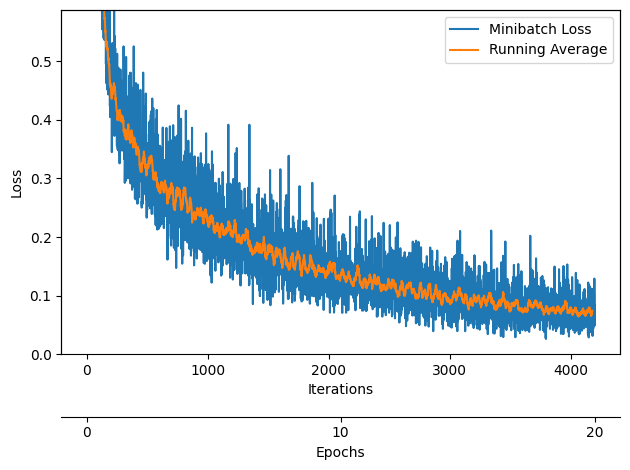

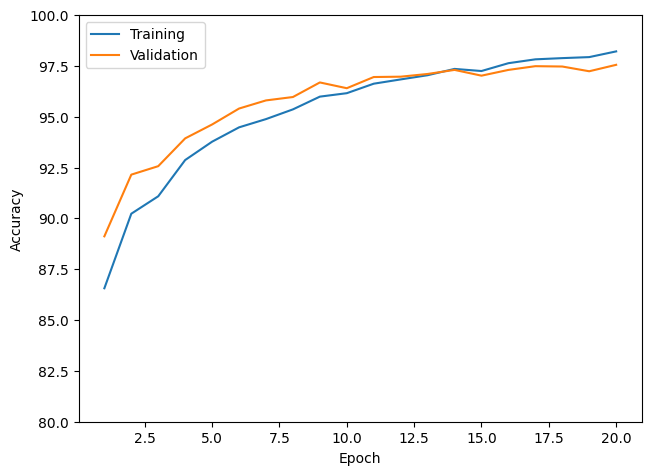

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

plt.ylim([80, 100])
plt.show()

Epoch: 001/050 | Batch 0000/0210 | Loss: 2.3156
Epoch: 001/050 | Batch 0050/0210 | Loss: 2.0492
Epoch: 001/050 | Batch 0100/0210 | Loss: 1.5094
Epoch: 001/050 | Batch 0150/0210 | Loss: 1.2816
Epoch: 001/050 | Batch 0200/0210 | Loss: 1.0073
Epoch: 001/050 | Train: 81.90% | Validation: 85.52%
Time elapsed: 0.27 min
Epoch: 002/050 | Batch 0000/0210 | Loss: 1.0743
Epoch: 002/050 | Batch 0050/0210 | Loss: 0.9386
Epoch: 002/050 | Batch 0100/0210 | Loss: 0.8110
Epoch: 002/050 | Batch 0150/0210 | Loss: 0.7741
Epoch: 002/050 | Batch 0200/0210 | Loss: 0.7683
Epoch: 002/050 | Train: 88.37% | Validation: 90.72%
Time elapsed: 0.52 min
Epoch: 003/050 | Batch 0000/0210 | Loss: 0.6099
Epoch: 003/050 | Batch 0050/0210 | Loss: 0.5885
Epoch: 003/050 | Batch 0100/0210 | Loss: 0.6093
Epoch: 003/050 | Batch 0150/0210 | Loss: 0.5235
Epoch: 003/050 | Batch 0200/0210 | Loss: 0.6620
Epoch: 003/050 | Train: 90.12% | Validation: 92.23%
Time elapsed: 0.78 min
Epoch: 004/050 | Batch 0000/0210 | Loss: 0.6923
Epoch: 

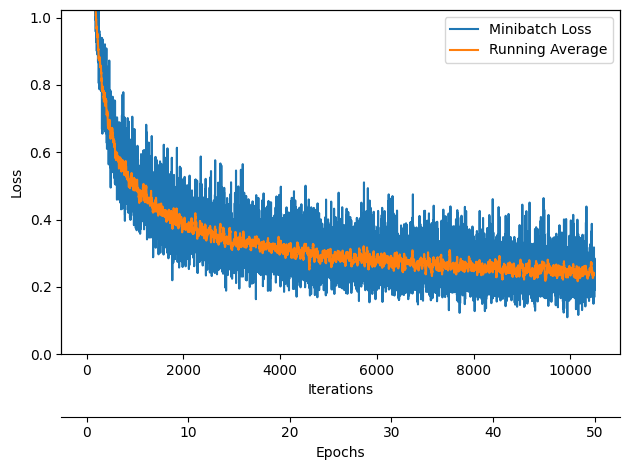

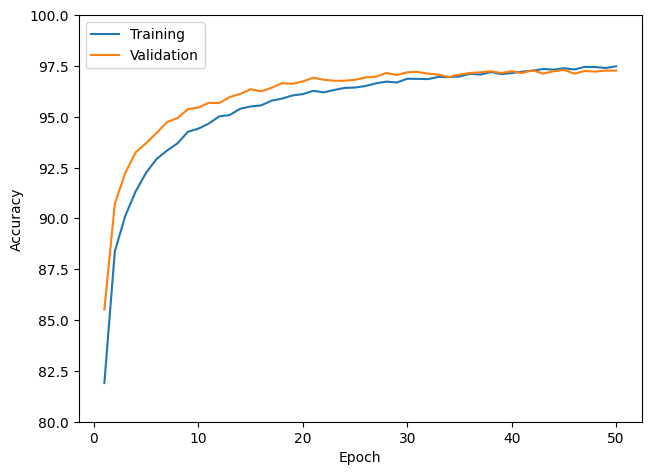

In [ ]:
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_proba=0.5,
                             num_classes=10)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()